0. Importing Packages

In [2]:
%pip install -q pandas geopandas numpy matplotlib unicode scipy scikit-learn palettable

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import glob
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
import matplotlib.colors as mcolors

import zipfile
import os

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

from matplotlib.colors import ListedColormap

import random


# 1. Cleaning data
## 1.1. Importing datasets

In [20]:
# List of files
data_folder = '../Data'
csv_files = glob.glob(f"{data_folder}/*.csv")

# Read each CSV file into a DataFrame and store in a list
dataframes = [pd.read_csv(file) for file in csv_files]

#IICA files
csv_iica = glob.glob(f"{data_folder}/*IICA/*.csv")
dataframes_iica = [pd.read_csv(file) for file in csv_iica]

#Fiscal performance files
csv_fisc = glob.glob(f"{data_folder}/*Terridata/*.csv")
dataframes_fisc = [pd.read_csv(file) for file in csv_fisc]


## 1.2. Cleaning datasets

In [21]:
#####################
### IICA datasets ###
#####################

### IICA 2002-2013 ###
dataframes_iica[0] = dataframes_iica[0].iloc[:, :5]
dataframes_iica[0] = dataframes_iica[0].rename(columns={
    'divipola': 'Divipola',
    'Departamento': 'Depto',
    'Municipio': 'Municipio',
    'año': 'year',
    'Índice de indicencia del conflicto': 'iica'
})

dataframes_iica[0]

,Divipola,Depto,Municipio,year,iica
0,5001,ANTIOQUIA,MEDELLÍN,2013,0.008261
1,5002,ANTIOQUIA,ABEJORRAL,2013,0.005499
2,5004,ANTIOQUIA,ABRIAQUÍ,2013,0.000327
3,5021,ANTIOQUIA,ALEJANDRÍA,2013,0.005062
4,5030,ANTIOQUIA,AMAGÁ,2013,0.016015
...,...,...,...,...,...
13459,97889,VAUPÉS,YAVARATÉ,2002,0.000185
13460,99001,VICHADA,PUERTO CARREÑO,2002,0.021377
13461,99524,VICHADA,LA PRIMAVERA,2002,0.010955
13462,99624,VICHADA,SANTA ROSALÍA,2002,0.012447


In [22]:
#####################
### IICA datasets ###
#####################

### IICA 2014-2016 ###
dataframes_iica[1] = pd.melt(dataframes_iica[1], id_vars=dataframes_iica[1].columns[:3], value_vars=dataframes_iica[1].columns[3:6], 
                    var_name='year', value_name='iica')

# Extract only the year number from the 'year' column
dataframes_iica[1]['year'] = dataframes_iica[1]['year'].str.extract('(\d+)').astype(int)

dataframes_iica[1]


<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\cpedr\AppData\Local\Temp\ipykernel_24864\673835912.py:10: SyntaxWarning: invalid escape sequence '\d'
  dataframes_iica[1]['year'] = dataframes_iica[1]['year'].str.extract('(\d+)').astype(int)


,Divipola,Depto,Municipio,year,iica
0,5001,ANTIOQUIA,MEDELLIN,2014,0.00692
1,5002,ANTIOQUIA,ABEJORRAL,2014,0.00738
2,5004,ANTIOQUIA,ABRIAQUI,2014,0.00070
3,5021,ANTIOQUIA,ALEJANDRIA,2014,0.00056
4,5030,ANTIOQUIA,AMAGA,2014,0.00925
...,...,...,...,...,...
3361,97889,VAUPÉS,YAVARATE,2016,0.00000
3362,99001,VICHADA,PUERTO CARREÑO,2016,0.01161
3363,99524,VICHADA,LA PRIMAVERA,2016,0.00745
3364,99624,VICHADA,SANTA ROSALIA,2016,0.00058


In [23]:
### IICA 2017-2022 ###
dataframes_iica[2] = pd.melt(dataframes_iica[2], id_vars=dataframes_iica[2].columns[1:4], value_vars=dataframes_iica[2].columns[4:10], 
                    var_name='year', value_name='iica')

# Extract only the year number from the 'year' column
dataframes_iica[2]['year'] = dataframes_iica[2]['year'].str.extract('(\d+)').astype(int)

dataframes_iica[2]

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\cpedr\AppData\Local\Temp\ipykernel_24864\3795539174.py:6: SyntaxWarning: invalid escape sequence '\d'
  dataframes_iica[2]['year'] = dataframes_iica[2]['year'].str.extract('(\d+)').astype(int)


,Divipola,Municipio,Depto,year,iica
0,5001,MEDELLIN,ANTIOQUIA,2017,0.02816
1,5002,ABEJORRAL,ANTIOQUIA,2017,0.00960
2,5004,ABRIAQUI,ANTIOQUIA,2017,0.03638
3,5021,ALEJANDRIA,ANTIOQUIA,2017,0.03846
4,5030,AMAGA,ANTIOQUIA,2017,0.03954
...,...,...,...,...,...
6721,97889,YAVARATE,VAUPÉS,2022,0.00000
6722,99001,PUERTO CARREÑO,VICHADA,2022,0.06498
6723,99524,LA PRIMAVERA,VICHADA,2022,0.03024
6724,99624,SANTA ROSALIA,VICHADA,2022,0.00344


In [24]:
# Merge all IICA datasets
merged_iica = pd.concat(dataframes_iica, ignore_index=True)

# From 2010 onwards
merged_iica = merged_iica[merged_iica["year"] >= 2010]
merged_iica = merged_iica.rename(columns={
    "Divipola": "codmpio"
})

merged_iica = merged_iica[['codmpio', 'year', 'iica']]
merged_iica

,codmpio,year,iica
0,5001,2013,0.008261
1,5002,2013,0.005499
2,5004,2013,0.000327
3,5021,2013,0.005062
4,5030,2013,0.016015
...,...,...,...
23551,97889,2022,0.000000
23552,99001,2022,0.064980
23553,99524,2022,0.030240
23554,99624,2022,0.003440


In [25]:
##########################
### Fiscal Performance ###
##########################

### New index ###

new_fisc = pd.read_excel("../Data/Terridata/fisc_new.xlsx")
new_fisc

,codmpio,year,fisc_perf
0,5001,2022,69.780160
1,5002,2022,65.498878
2,5004,2022,63.304395
3,5021,2022,51.872702
4,5030,2022,64.425324
...,...,...,...
3299,99773,2021,24.066327
3300,99624,2021,22.616307
3301,19318,2021,16.666667
3302,99001,2021,16.666667


In [26]:
### Old Index ###
old_fisc = dataframes_fisc[0][dataframes_fisc[0]['Indicador'] == 'Indicador de desempeño fiscal']
old_fisc['Dato Numérico'] = old_fisc['Dato Numérico'].str.replace(',', '.').astype(float)
old_fisc = old_fisc.iloc[:, [2, 7, 9]]
old_fisc = old_fisc.rename(columns={
    'Código Entidad': 'codmpio',
    'Dato Numérico': 'fisc_perf',
    'Año': 'year', 
})

old_fisc = old_fisc[(old_fisc["year"] >= 2010) & (old_fisc["year"] < 2020)]
old_fisc

C:\Users\cpedr\AppData\Local\Temp\ipykernel_24864\3928155548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_fisc['Dato Numérico'] = old_fisc['Dato Numérico'].str.replace(',', '.').astype(float)


,codmpio,fisc_perf,year
125,1001.0,NaN,2010.0
126,1001.0,NaN,2011.0
127,1001.0,NaN,2012.0
128,1001.0,NaN,2013.0
129,1001.0,NaN,2014.0
...,...,...,...
166826,99773.0,76.15,2015.0
166827,99773.0,60.25,2016.0
166828,99773.0,55.16,2017.0
166829,99773.0,NaN,2018.0


In [27]:
###########################
### Working the accents ###
###########################

# Function to remove accents while preserving special cases
def remove_accents(input_string):
    if input_string in ["Ñ", "Ü"]:
        return input_string
    return unidecode(input_string)

In [28]:
################
### Divipola ###
################

codes = dataframes[2]
codes = codes.rename(columns={
    'Código Municipio': 'codmpio',
    'Nombre Departamento': 'Departamento',
    'Nombre Municipio': 'Municipio'
})

codes["Departamento"] = codes["Departamento"].apply(remove_accents)
codes["Municipio"] = codes["Municipio"].apply(remove_accents)

codmpios = codes["codmpio"].unique()

codes = codes[['codmpio', 'Departamento', 'Municipio']].drop_duplicates()
codes

,codmpio,Departamento,Municipio
0,5001,ANTIOQUIA,MEDELLIN
55,5002,ANTIOQUIA,ABEJORRAL
64,5004,ANTIOQUIA,ABRIAQUI
66,5021,ANTIOQUIA,ALEJANDRIA
67,5030,ANTIOQUIA,AMAGA
...,...,...,...
9174,97889,VAUPES,YAVARATE
9176,99001,VICHADA,PUERTO CARRENO
9179,99524,VICHADA,LA PRIMAVERA
9186,99624,VICHADA,SANTA ROSALIA


In [29]:
# Merge all fiscal performance datasets
merged_fisc = pd.concat([old_fisc, new_fisc], ignore_index=True)

# Display the merged dataframe
merged_fisc = merged_fisc[merged_fisc["codmpio"].isin(codmpios)]

# Get rid of years before municipality 94343 was founded
merged_fisc = merged_fisc[~((merged_fisc["fisc_perf"].isna()) & (merged_fisc['codmpio'] == 94343))]

# Ensure the data is sorted correctly before interpolation
merged_fisc = merged_fisc.sort_values(by=['codmpio', 'year'])

# Linear Interpolation (between years) for municipalities with random missing values
merged_fisc['fisc_perf'] = merged_fisc.groupby('codmpio')['fisc_perf'].transform(lambda x: x.interpolate())

merged_fisc

,codmpio,fisc_perf,year
18,5001.0,89.430000,2010.0
19,5001.0,84.360000,2011.0
20,5001.0,83.220000,2012.0
21,5001.0,84.820000,2013.0
22,5001.0,85.500000,2014.0
...,...,...,...
11346,99773.0,61.960000,2018.0
11347,99773.0,68.760000,2019.0
13279,99773.0,62.680053,2020.0
14647,99773.0,24.066327,2021.0


In [30]:
###########
### GDP ###
###########

# Read the Excel file
gdp = pd.read_excel("../Data/anex-PIBDep-ValorAgreMuni-2011-2022p.xlsx", 
                    sheet_name="Cuadro 1", skiprows=10, nrows=1122)

# Drop unnecessary columns
gdp = gdp.drop(columns=["Código Departamento", "Departamento", "Municipio ", "Unnamed: 16", "Unnamed: 17"])

# Rename columns
gdp = gdp.rename(columns={
    "Código Municipio": "codmpio",
    "2021p": "2021",
    "2022p": "2022"
})

# Reshape data from wide to long format
gdp = gdp.melt(id_vars=["codmpio"], var_name="year", value_name="gdp")
gdp['gdp'] = gdp['gdp']*1000

gdp


,codmpio,year,gdp
0,5001,2011,3.444253e+07
1,5002,2011,1.271750e+05
2,5004,2011,1.754917e+04
3,5021,2011,8.998268e+04
4,5030,2011,2.169485e+05
...,...,...,...
13459,97889,2022,3.567078e+03
13460,99001,2022,1.777020e+05
13461,99524,2022,2.445231e+05
13462,99624,2022,1.221738e+05


In [31]:
# Old values
gdp_old = dataframes[5][['codmpio', 'ano', 'pib_total']]

# Rename columns
gdp_old = gdp_old.rename(columns={
    "ano": "year",
    "pib_total": "gdp"
})

# Drop NAs
gdp_old = gdp_old.dropna(subset=['gdp'])


In [32]:
# Merge gdp datasets
gdp = pd.concat([gdp, gdp_old], ignore_index=True)

# Identify municipalities that need interpolation
municipalities = gdp["codmpio"].unique()

# Create a new DataFrame for interpolated 2010 values
interpolated_rows = []

for municipality in municipalities:
    # Get GDP values for 2009 and 2011 for the current municipality
    gdp_2009 = gdp[(gdp["codmpio"] == municipality) & (gdp["year"] == 2009)]["gdp"].values
    gdp_2011 = gdp[(gdp["codmpio"] == municipality) & (gdp["year"] == 2011)]["gdp"].values
    
    # Ensure both years exist for interpolation
    if len(gdp_2009) > 0 and len(gdp_2011) > 0:
        # Perform linear interpolation
        gdp_2010 = (gdp_2009[0] + gdp_2011[0]) / 2
        
        # Append interpolated row
        interpolated_rows.append({"codmpio": municipality, "year": 2010, "gdp": gdp_2010})

# Convert interpolated data to DataFrame
gdp_interpolated = pd.DataFrame(interpolated_rows)

# Append interpolated data to the main dataset
gdp = pd.concat([gdp, gdp_interpolated], ignore_index=True)

# Sort dataset by municipality and year
gdp = gdp.sort_values(by=["codmpio", "year"]).reset_index(drop=True)

# Drop duplicates
gdp = gdp.drop_duplicates(subset=["codmpio", "year", "gdp"])

# Subset years
gdp["year"] = gdp["year"].astype(int)
gdp = gdp[gdp["year"] >= 2010]
gdp

,codmpio,year,gdp
10,5001,2010,2.964083e+07
11,5001,2011,3.444253e+07
12,5001,2012,3.692472e+07
13,5001,2013,4.088087e+07
14,5001,2014,4.304234e+07
...,...,...,...
25526,99773,2018,2.728310e+05
25527,99773,2019,2.756950e+05
25528,99773,2020,2.766593e+05
25529,99773,2021,3.169662e+05


In [33]:
###################
### Shape files ###
###################

# Read the shapefile
shapes = gpd.read_file('../Data/shapes/shapes.shp')

# Keep relevant variables
shapes = shapes[["mpios", "geometry"]]

# mpios changes
shapes = shapes.rename(columns={
  "mpios": "codmpio"       
})
shapes["codmpio"] = shapes["codmpio"].astype(int)

# Display the updated shapes dataset to verify the hectares variable
shapes = gpd.GeoDataFrame(shapes, geometry="geometry")
shapes

,codmpio,geometry
0,5873,"POLYGON ((-76.90331 6.83561, -76.90562 6.82957..."
1,5686,"POLYGON ((-75.6099 6.8743, -75.6071 6.8708, -7..."
2,5284,"POLYGON ((-76.2441 6.9174, -76.2227 6.9167, -7..."
3,5315,"POLYGON ((-75.2312 6.9374, -75.2232 6.9287, -7..."
4,68895,"POLYGON ((-73.2425 6.9088, -73.2309 6.9047, -7..."
...,...,...
1117,47205,"POLYGON ((-74.69577 10.22744, -74.69933 10.226..."
1118,47960,"POLYGON ((-74.70518 10.27644, -74.69872 10.263..."
1119,17380,"POLYGON ((-74.6766 5.7584, -74.6754 5.7463, -7..."
1120,27150,"POLYGON ((-76.89271 7.24821, -76.89113 7.22927..."


In [34]:
codes

,codmpio,Departamento,Municipio
0,5001,ANTIOQUIA,MEDELLIN
55,5002,ANTIOQUIA,ABEJORRAL
64,5004,ANTIOQUIA,ABRIAQUI
66,5021,ANTIOQUIA,ALEJANDRIA
67,5030,ANTIOQUIA,AMAGA
...,...,...,...
9174,97889,VAUPES,YAVARATE
9176,99001,VICHADA,PUERTO CARRENO
9179,99524,VICHADA,LA PRIMAVERA
9186,99624,VICHADA,SANTA ROSALIA


In [35]:
################################
### Deforestation with codes ###
################################
deforestation = dataframes[1]

# Apply function to remove accents
deforestation["subnational1"] = deforestation["subnational1"].str.upper().apply(remove_accents)
deforestation["subnational2"] = deforestation["subnational2"].str.upper().apply(remove_accents)

# Finding non-matching names: towns
non_matching_towns = set(codes["Municipio"]) - set(deforestation["subnational2"])
print(len(non_matching_towns))  # 88 do not match
print(len(set(codes["Municipio"])) - len(set(deforestation["subnational2"])))
print(non_matching_towns)

# Finding non-matching names: departments
non_matching_departments = set(codes["Municipio"]) - set(deforestation["subnational1"])
print(len(non_matching_departments))  # 2 do not match
print(len(set(codes["Municipio"])) - len(set(deforestation["subnational1"])))
print(non_matching_departments)

# Manually updating values
replace_dict_subnational1 = {
    ("CUNDINAMARCA", "SANTAFE DE BOGOTA"): "BOGOTA, D.C.",
    "SAN ANDRES Y PROVIDENCIA": "ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA"
}

replace_dict_subnational2 = {
    ("ANTIOQUIA", "BOLIVAR"): "CIUDAD BOLIVAR",
    ("ANTIOQUIA", "CAROLINA DEL PRINCIPE"): "CAROLINA",
    "DON MATIAS": "DONMATIAS",
    "LA UNION DE SUCRE": "LA UNION",
    "SAN VICENTE": "SAN VICENTE FERRER",
    "SANTAFE DE BOGOTA": "BOGOTA, D.C.",
    "SAN ESTANISLAO DE KOSTKA": "SAN ESTANISLAO",
    ("BOYACA", "CIENAGA"): "CIENEGA",
    "GUICAN": "GÜICAN",
    "TOGUI": "TOGÜI",
    ("CESAR", "MANAURE"): "MANAURE BALCON DEL CESAR",
    "SANTA CRUZ DE LORICA": "LORICA",
    "PURISIMA": "PURISIMA DE LA CONCEPCION",
    "SAN BERNARDINO DE SAHAGUN": "SAHAGUN",
    "SAN JUAN DE RIO SECO": "SAN JUAN DE RIOSECO",
    "SANTA MARTA (DIST. ESP.)": "SANTA MARTA",
    "PUEBLO VIEJO": "PUEBLOVIEJO",
    "LA URIBE": "URIBE",
    "VISTA HERMOSA": "VISTAHERMOSA",
    "SAN JUAN DE PASTO": "PASTO",
    "SANTA CRUZ": "SANTACRUZ",
    "TUMACO": "SAN ANDRES DE TUMACO",
    "SAN JOSE DE CUCUTA": "CUCUTA",
    "LA PLAYA DE BELEN": "LA PLAYA",
    "SALAZAR DE LAS PALMAS": "SALAZAR",
    "SANTO DOMINGO DE SILOS": "SILOS",
    "SAN ANTONIO DE PALMITO": "PALMITO",
    "SINCE": "SAN LUIS DE SINCE",
    "TOLU": "SANTIAGO DE TOLU",
    "TOLUVIEJO": "TOLU VIEJO",
    "ARMERO": "ARMERO GUAYABAL",
    "SANTIAGO DE CALI": "CALI",
    "SAN MIGUEL DE MOCOA": "MOCOA",
    "MIRITI-PARANA": "MIRITI - PARANA",
    "PUERTO INIRIDA": "INIRIDA",
    "PAPUNAHUA": "PAPUNAUA"
}

deforestation["subnational1"] = deforestation.apply(
    lambda row: replace_dict_subnational1.get((row["subnational1"], row["subnational2"]), 
                                              replace_dict_subnational1.get(row["subnational1"], row["subnational1"])), axis=1
)

deforestation["subnational2"] = deforestation.apply(
    lambda row: replace_dict_subnational2.get((row["subnational1"], row["subnational2"]), 
                                              replace_dict_subnational2.get(row["subnational2"], row["subnational2"])), axis=1
)

# Merge datasets
def_codes = pd.merge(deforestation, codes, left_on=["subnational1", "subnational2"], right_on=["Departamento", "Municipio"], how="left")

def_codes


86
52
{'DIBULLA', 'LA PLAYA', 'DISTRACCION', 'SANTIAGO DE TOLU', 'SAN ANDRES DE TUMACO', 'SAHAGUN', 'PALOCABILDO', 'TIQUISIO', 'PIJINO DEL CARMEN', 'SAN CRISTOBAL', 'SOLITA', 'UNION PANAMERICANA', 'MIRITI - PARANA', 'NOROSI', 'MEDIO BAUDO', 'SALAZAR', 'COVENAS', 'CUCUTA', 'EL RETEN', 'LORICA', 'MAGANGUE', 'LA JAGUA DEL PILAR', 'SANTA BARBARA DE PINTO', 'CIENEGA', 'LA UNION', 'VILLA RICA', 'EL PENOL', 'HATONUEVO', 'PUEBLOVIEJO', 'URIBE', 'SANTA MARTA', 'LA PINTADA', 'CALI', 'SAN VICENTE FERRER', 'MEDIO SAN JUAN', 'PUEBLO BELLO', 'CLEMENCIA', 'NUEVA GRANADA', 'ARENAL', 'BOGOTA, D.C.', 'NORCASIA', 'MOCOA', 'TUCHIN', 'LA APARTADA', 'CERTEGUI', 'CAROLINA', 'SAN ESTANISLAO', 'ZONA BANANERA', 'INIRIDA', 'CARMEN DEL DARIEN', 'SAN JOSE DE URE', 'SANTACRUZ', 'SITIONUEVO', 'SAN JACINTO DEL CAUCA', 'COTORRA', 'VISTAHERMOSA', 'PASTO', 'ARMERO GUAYABAL', 'MANAURE BALCON DEL CESAR', 'MEDIO ATRATO', 'RIO QUITO', 'ALGARROBO', 'ZAPAYAN', 'ARROYOHONDO', 'PALMITO', 'PUERTO ARICA', 'CIUDAD BOLIVAR', 'SILOS

,country,subnational1,subnational2,threshold,area_ha,extent_2000_ha,extent_2010_ha,gain_2000-2020_ha,tc_loss_ha_2001,tc_loss_ha_2002,...,tc_loss_ha_2017,tc_loss_ha_2018,tc_loss_ha_2019,tc_loss_ha_2020,tc_loss_ha_2021,tc_loss_ha_2022,tc_loss_ha_2023,codmpio,Departamento,Municipio
0,Colombia,AMAZONAS,EL ENCANTO,0,1027642,1027642,1027642,773,212,182,...,322,178,219,392,299,334,224,91263.0,AMAZONAS,EL ENCANTO
1,Colombia,AMAZONAS,EL ENCANTO,10,1027642,1010468,1010236,773,212,182,...,316,176,218,386,295,320,217,91263.0,AMAZONAS,EL ENCANTO
2,Colombia,AMAZONAS,EL ENCANTO,15,1027642,1010422,1010189,773,212,182,...,316,176,218,386,295,320,217,91263.0,AMAZONAS,EL ENCANTO
3,Colombia,AMAZONAS,EL ENCANTO,20,1027642,1010269,1010088,773,212,182,...,316,176,217,386,295,319,217,91263.0,AMAZONAS,EL ENCANTO
4,Colombia,AMAZONAS,EL ENCANTO,25,1027642,1010200,1010045,773,212,182,...,315,176,217,386,294,319,217,91263.0,AMAZONAS,EL ENCANTO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,Colombia,VICHADA,SANTA ROSALIA,20,432087,43805,47538,6493,77,122,...,53,28,27,44,79,31,38,99624.0,VICHADA,SANTA ROSALIA
8516,Colombia,VICHADA,SANTA ROSALIA,25,432087,43022,45935,6493,76,121,...,52,28,27,44,79,31,37,99624.0,VICHADA,SANTA ROSALIA
8517,Colombia,VICHADA,SANTA ROSALIA,30,432087,41681,43871,6493,75,120,...,51,28,27,43,78,31,36,99624.0,VICHADA,SANTA ROSALIA
8518,Colombia,VICHADA,SANTA ROSALIA,50,432087,36801,36327,6493,66,110,...,49,25,27,42,77,29,31,99624.0,VICHADA,SANTA ROSALIA


In [36]:
#####################
### Deforestation ###
#####################

# Select only numeric columns
numeric_cols = def_codes.select_dtypes(include=[np.number]).columns

# Group by 'subnational1' and 'subnational2' and calculate the mean for tree cover loss for all thresholds
def_codes = def_codes.groupby(['subnational1', 'subnational2'])[numeric_cols].mean()
def_codes.reset_index(inplace=True)
def_codes = def_codes.iloc[:, list(range(0, 2)) + list(range(7, def_codes.shape[1]))]

# Wide to long
def_codes = pd.melt(def_codes, id_vars=list(def_codes.columns[[0, 1, 25]]), value_vars=def_codes.columns[2:25], 
                    var_name='year', value_name='tc_loss')

# Extract only the year number from the 'year' column
def_codes['year'] = def_codes['year'].str.extract('(\d+)')
# Drop rows with NaN values in the 'year' column
def_codes = def_codes.dropna(subset=['year'])

# Convert the 'year' column to integers
def_codes['year'] = def_codes['year'].astype(int)


def_codes


<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
C:\Users\cpedr\AppData\Local\Temp\ipykernel_24864\2868152401.py:18: SyntaxWarning: invalid escape sequence '\d'
  def_codes['year'] = def_codes['year'].str.extract('(\d+)')


,subnational1,subnational2,codmpio,year,tc_loss
0,AMAZONAS,EL ENCANTO,91263.0,2001,212.000
1,AMAZONAS,LA CHORRERA,91405.0,2001,285.000
2,AMAZONAS,LA PEDRERA,91407.0,2001,139.000
3,AMAZONAS,LETICIA,91001.0,2001,180.750
4,AMAZONAS,MIRITI - PARANA,91460.0,2001,125.000
...,...,...,...,...,...
24490,VICHADA,LA PRIMAVERA,99524.0,2023,338.125
24491,VICHADA,PUERTO CARRENO,99001.0,2023,199.500
24492,VICHADA,SAN JOSE DE OCUNE,NaN,2023,2375.250
24493,VICHADA,SANTA RITA,NaN,2023,917.375


In [37]:
###############################
### General Characteristics ###
###############################
general = dataframes[5][["codmpio", "ano", "gandina", "gcaribe", "gpacifica", "gorinoquia", "gamazonia",
                         "areaoficialhm2", "discapital", "dismdo", "disbogota", "pobl_rur", "pobl_urb"]]

# Identify dummy columns starting with 'g'
dummy_cols = [col for col in general.columns if col.startswith("g")]

# Convert dummies to a single categorical column
general['Region'] = general[dummy_cols].idxmax(axis=1).str.replace("g", "").str.capitalize()

# Drop the original dummy columns
general = general.drop(columns=dummy_cols)

# Convert to categorical type if needed
general['Region'] = general['Region'].astype('category')

# Subset years
general = general.rename(columns={
    "ano": "year"
})
general = general[general["year"] >= 2010]

# Fix vars as numeric
general["pobl_rur"] = general["pobl_rur"].str.replace(",", "").astype(int)
general["pobl_urb"] = general["pobl_urb"].str.replace(",", "").astype(int)

general

C:\Users\cpedr\AppData\Local\Temp\ipykernel_24864\1699620150.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general['Region'] = general[dummy_cols].idxmax(axis=1).str.replace("g", "").str.capitalize()


,codmpio,year,areaoficialhm2,discapital,dismdo,disbogota,pobl_rur,pobl_urb,Region
17,5001,2010,38700,0,0.0,264,33603,2309446,Andina
18,5001,2011,38700,0,0.0,264,32714,2335568,Andina
19,5001,2012,38700,0,0.0,264,31877,2361134,Andina
20,5001,2013,38700,0,0.0,264,31092,2386233,Andina
21,5001,2014,38700,0,0.0,264,30358,2410765,Andina
...,...,...,...,...,...,...,...,...,...
34772,99773,2019,6567400,92,NaN,594,73053,3143,Orinoquia
34773,99773,2020,6567400,92,NaN,594,75490,3373,Orinoquia
34774,99773,2021,6567400,92,NaN,594,76648,3336,Orinoquia
34775,99773,2022,6567400,92,NaN,594,77681,3156,Orinoquia


In [719]:
#####################
### DNP variables ###
#####################
dnp = pd.read_excel("../Data/dnp&conflict.xlsx", sheet_name="dnp")


dnp

,codmpio,year,ICM-00-0,PCC-00-0,GPI-00-0,EIS-00-0,CTI-00-0,SEG-00-0,SOS-00-0,CTI-01-0,...,P-01-25,PCC-01-2,PCC-02-1,C-03-14,PCC-02-3,PCC-02-3a,PCC-02-4,C-03-13,P-01-46,P-01-34-1
0,5001,2010,61.778803,69.808832,57.020339,77.763193,51.604878,61.920977,52.554598,90.243036,...,1,45.165549,100.000000,12.590432,99.751839,100.000000,50.000000,1,1.217692,4
1,5002,2010,36.877388,13.274066,42.630910,27.906347,15.394641,81.251959,40.806405,0.000000,...,6,0.119256,0.000000,15.189873,0.136642,0.078778,0.039389,0,2.812876,2
2,5004,2010,37.418546,12.190160,34.715235,23.098531,12.213658,90.612233,51.681457,0.000000,...,7,0.028054,0.000000,0.000000,0.018914,0.028961,50.014481,0,3.078961,1
3,5021,2010,42.145031,20.613866,35.162800,33.240817,14.400115,100.000000,49.452589,0.000000,...,6,0.311132,16.666667,0.000000,0.001898,0.000204,50.000102,0,2.812876,2
4,5030,2010,45.644138,29.861126,51.023982,37.200685,21.888866,73.457439,60.432733,40.243036,...,6,1.222963,100.000000,17.585200,3.236933,1.193646,0.596823,0,2.325791,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14581,97889,2022,38.166803,27.380984,27.149309,6.341531,7.968225,100.000000,60.160768,0.000000,...,7,0.000192,NaN,0.000000,NaN,NaN,100.000000,0,3.078961,1
14582,99001,2022,25.044591,23.117975,24.020616,45.687006,9.770763,12.500000,35.171187,9.676831,...,6,0.003083,100.000000,5.698330,0.002100,0.051486,0.025743,1,3.078961,1
14583,99524,2022,35.950003,9.861347,34.177003,26.399368,12.357321,93.626817,39.278162,2.604773,...,7,0.002972,0.000000,5.119279,0.007657,0.186255,6.672609,1,3.078961,1
14584,99624,2022,35.348132,14.939526,27.521499,33.075715,16.188728,53.227982,67.135341,3.521524,...,7,0.006834,0.000000,0.000000,0.013507,3.763130,51.881565,1,3.078961,1


In [720]:
### Conflic CEDE ###
conflict = pd.read_excel("../Data/dnp&conflict.xlsx", sheet_name="conflict")

conflict = conflict.fillna(0)

conflict

,codmpio,year,H_coca,errad_manual,terrorismot,pirateria_terr,e_amenaza,e_confina,e_delito_sex,e_desap_for,e_desplaza,e_minas_anti,e_tortura,e_vinc_mened,eventos_minas
0,5001,2010,0.00,0.000000,9.0,49.0,823.0,0.0,10.0,39.0,12033.0,0.0,4.0,8.0,3.0
1,5001,2011,0.00,0.000000,13.0,58.0,1393.0,0.0,33.0,34.0,18471.0,0.0,0.0,4.0,1.0
2,5001,2012,0.00,0.000000,19.0,62.0,7212.0,0.0,23.0,19.0,18094.0,1.0,4.0,9.0,3.0
3,5001,2013,0.00,0.000000,12.0,61.0,3936.0,0.0,31.0,0.0,12315.0,2.0,4.0,0.0,1.0
4,5001,2014,0.00,0.000000,0.0,16.0,2927.0,0.0,27.0,0.0,8872.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15705,99773,2019,245.30,308.270000,0.0,0.0,80.0,0.0,4.0,0.0,302.0,0.0,0.0,0.0,3.0
15706,99773,2020,120.98,203.978900,1.0,0.0,44.0,0.0,2.0,0.0,94.0,0.0,0.0,0.0,0.0
15707,99773,2021,310.83,52.751099,0.0,0.0,42.0,0.0,2.0,0.0,192.0,0.0,0.0,2.0,0.0
15708,99773,2022,282.70,0.000000,0.0,0.0,110.0,0.0,4.0,0.0,192.0,0.0,2.0,0.0,0.0


In [721]:
############
### Agro ###
############

agro = dataframes[0]

# Drop columns with only missing values
agro = agro.dropna(axis=1, how="all")

# Drop rows with missing values for all columns for 17th column onwards
agro = agro[~agro[agro.columns[2:]].isna().all(axis=1)]

# Fill missing values with 0
agro.fillna(0, inplace=True)

# Dictionary of prefixes and their corresponding total column names
prefixes = {
    "ac_": "total_ac",  # Harvested area
    "as_": "total_as",  # Sowed area
    "p_": "total_p",    # Production
    "r_": "total_r",    # Performance
    "nuf_": "total_nuf", # Number of credits
    "vrf_": "total_vrf"  # Value of credits
}

# Create new columns with the sum for each variable group
for prefix, total_col in prefixes.items():
    agro[total_col] = agro.filter(like=prefix).sum(axis=1)

# Drop rows with 0 for all the total columns
agro = agro[agro[list(prefixes.values())].sum(axis=1) > 0]

# Keep the first two columns + the total ones
columns_to_keep = list(agro.columns[:2]) + [col for col in agro.columns if col.startswith("total_")]

agro = agro[columns_to_keep]
agro = agro.rename(columns={
    "ano": "year"
})

agro = agro[agro["year"] >= 2010]

agro

,codmpio,year,total_ac,total_as,total_p,total_r,total_nuf,total_vrf
7,5001,2010,2099.0,2215.0,13638.0,469.0,503.0,68340.0
8,5001,2011,2094.0,2238.0,16880.0,441.0,458.0,137060.0
9,5001,2012,2198.0,2298.0,18119.0,447.0,499.0,203706.0
10,5001,2013,1671.0,1833.0,17491.0,447.0,468.0,350312.0
11,5001,2014,1610.0,1806.0,17748.0,447.0,482.0,367059.0
...,...,...,...,...,...,...,...,...
23285,99773,2019,2858.0,3695.0,23280.0,144.0,80.0,1622.0
23286,99773,2020,2526.0,3477.0,11347.0,33.0,164.0,3036.0
23287,99773,2021,2873.0,3095.0,16705.0,95.0,127.0,7822.0
23288,99773,2022,2973.0,3079.0,19521.0,158.0,129.0,10643.0


In [726]:
### Merge all ###
final_df = pd.merge(codes, merged_iica, on="codmpio", how="left")
final_df = pd.merge(final_df, shapes, on="codmpio", how="left")
final_df = pd.merge(final_df, merged_fisc, on=["codmpio", "year"], how="left")
final_df = pd.merge(final_df, gdp, on=["codmpio", "year"], how="left")
final_df = pd.merge(final_df, general, on=["codmpio", "year"], how="left")

# Ged GDP per capita
final_df["gdp_pc"] = final_df["gdp"] / (final_df["pobl_rur"] + final_df["pobl_urb"]) # Times 1 million 

# Keep merging
final_df = pd.merge(final_df, agro, on=["codmpio", "year"], how="left")
final_df = pd.merge(final_df, conflict, on=["codmpio", "year"], how="left")
final_df = pd.merge(final_df, dnp, on=["codmpio", "year"], how="left")

# Work with deforestation variable
final_df = final_df.rename(columns={
    "M-03-25": "f_loss"
})

final_df["pc_loss"] = (final_df["f_loss"] / final_df["areaoficialhm2"])*100

# Reorganize variables
selected_columns = ["codmpio", "Departamento", "Municipio", "Region", "geometry", "year", "f_loss", "pc_loss", "areaoficialhm2", "gdp", "gdp_pc"]  

# Reorder the dataset: Keep selected columns first, then the rest
remaining_columns = [col for col in final_df.columns if col not in selected_columns]
new_column_order = selected_columns + remaining_columns  

# Apply the new column order
final_df = final_df[new_column_order]

# Sort the dataset by `codmpio` and `year`
final_df = final_df.sort_values(by=["codmpio", "year"]).reset_index(drop=True)

final_df = gpd.GeoDataFrame(final_df, geometry="geometry")

final_df


,codmpio,Departamento,Municipio,Region,geometry,year,f_loss,pc_loss,areaoficialhm2,gdp,...,P-01-25,PCC-01-2,PCC-02-1,C-03-14,PCC-02-3,PCC-02-3a,PCC-02-4,C-03-13,P-01-46,P-01-34-1
0,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2010,30.154418,0.077918,38700,2.964083e+07,...,1,45.165549,100.0,12.590432,99.751839,100.000000,50.000000,1,1.217692,4
1,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2011,25.695615,0.066397,38700,3.444253e+07,...,1,45.245880,100.0,12.920759,99.751839,100.000000,50.000000,1,1.217692,4
2,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2012,29.345245,0.075828,38700,3.692472e+07,...,1,46.737400,100.0,11.617163,99.751839,100.000000,50.000000,1,1.217692,4
3,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2013,18.412226,0.047577,38700,4.088087e+07,...,1,50.976367,100.0,12.658621,99.751839,100.000000,50.000000,1,1.217692,4
4,5001,ANTIOQUIA,MEDELLIN,Andina,"POLYGON ((-75.6754 6.3812, -75.6754 6.3749, -7...",2014,43.509827,0.112428,38700,4.304234e+07,...,1,49.602144,100.0,11.879778,89.775347,90.355662,45.177831,1,1.217692,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,99773,VICHADA,CUMARIBO,Orinoquia,"POLYGON ((-68.5412 5.437, -68.5118 5.4467, -68...",2018,5986.956176,0.091162,6567400,2.728310e+05,...,5,0.001109,0.0,0.000000,0.185979,1.158266,40.105233,1,3.078961,1
14602,99773,VICHADA,CUMARIBO,Orinoquia,"POLYGON ((-68.5412 5.437, -68.5118 5.4467, -68...",2019,5318.000000,0.080976,6567400,2.756950e+05,...,5,0.001075,0.0,2.469746,0.091892,0.450848,29.522425,1,3.078961,1
14603,99773,VICHADA,CUMARIBO,Orinoquia,"POLYGON ((-68.5412 5.437, -68.5118 5.4467, -68...",2020,3986.000000,0.060694,6567400,2.766593e+05,...,5,0.001052,0.0,2.412022,0.117194,0.502259,29.548131,1,3.078961,1
14604,99773,VICHADA,CUMARIBO,Orinoquia,"POLYGON ((-68.5412 5.437, -68.5118 5.4467, -68...",2021,3702.330583,0.056374,6567400,3.169662e+05,...,5,0.001125,0.0,0.000000,0.136256,0.458311,20.455470,1,3.078961,1


# 2. First Graphs for trends and clustering

In [728]:
# Read the shapefile
transition_df = final_df.copy()

overall_f_loss = final_df['f_loss'].sum()
overall_coca = final_df['H_coca'].sum()
# Keep relevant variables
transition_df = transition_df[["Departamento", "Municipio", "year", "f_loss", "H_coca", "geometry"]]
# Group by Municipio and calculate the sum of f_loss for each 
transition_df = transition_df.groupby(["Departamento", "Municipio", "geometry"]).agg({
    "f_loss": "sum",
    "H_coca": "sum"
}).reset_index()
transition_df["contribution_f"] = transition_df["f_loss"] / overall_f_loss * 100
transition_df["contribution_c"] = transition_df["H_coca"] / overall_coca * 100

# Define the departments and specific municipios for "META"
desired_departamentos = ['PUTUMAYO', 'CAQUETA', 'GUAVIARE', 'META']
desired_municipios_for_meta = ['LA MACARENA', 'URIBE', 'MESETAS', 'VISTAHERMOSA',
                               'PUERTO RICO', 'PUERTO CONCORDIA', 'GUAMAL',
                               'SAN LUIS DE CUBARRAL', 'EL DORADO', 'EL CASTILLO',
                               'LEJANIAS', 'SAN JUAN DE ARAMA', 'GRANADA',
                               'FUENTE DE ORO', 'PUERTO LLERAS']

# Filter rows where Departamento is in the desired list
# and for "META" only include rows with the desired Municipio values.
transition_df = transition_df[
    (transition_df['Departamento'].isin(desired_departamentos)) &
    (
        (transition_df['Departamento'] != 'META') | 
        (transition_df['Municipio'].isin(desired_municipios_for_meta))
    )
]

transition_df = gpd.GeoDataFrame(transition_df, geometry='geometry')
transition = transition_df.dissolve()

In [729]:
print(transition_df["contribution_f"].sum())
transition_df["contribution_c"].sum()

54.598227303934266


27.200069813271046

In [730]:
transition_df.sort_values(by="contribution_f", ascending=False, inplace=True)
transition_df

,Departamento,Municipio,geometry,f_loss,H_coca,contribution_f,contribution_c
376,CAQUETA,SAN VICENTE DEL CAGUAN,"POLYGON ((-74.9206 2.9441, -74.9159 2.9406, -7...",201511.774310,2753.95,9.244186,0.169543
366,CAQUETA,CARTAGENA DEL CHAIRA,"POLYGON ((-75.2558 1.4293, -75.2373 1.4373, -7...",192570.560638,9139.69,8.834016,0.562673
747,META,LA MACARENA,"POLYGON ((-74.6891 2.4793, -74.6326 2.4785, -7...",150366.698820,7861.60,6.897948,0.483989
653,GUAVIARE,SAN JOSE DEL GUAVIARE,"POLYGON ((-72.3812 2.7319, -72.3644 2.7451, -7...",123145.681159,17193.55,5.649207,1.058499
874,PUTUMAYO,PUERTO GUZMAN,"POLYGON ((-76.4545 0.9762, -76.4395 0.9692, -7...",68169.359996,18154.00,3.127213,1.117628
377,CAQUETA,SOLANO,"POLYGON ((-75.3738 1.1363, -75.3657 1.1536, -7...",57189.478529,11549.10,2.623520,0.711006
651,GUAVIARE,EL RETORNO,"POLYGON ((-70.4999 2.1966, -70.4912 2.1989, -7...",56173.817667,20433.33,2.576928,1.257952
650,GUAVIARE,CALAMAR,"POLYGON ((-72.93246 1.98724, -72.9243 1.978, -...",52374.929662,5261.41,2.402657,0.323912
762,META,URIBE,"POLYGON ((-74.2529 3.6841, -74.2523 3.6633, -7...",43123.001470,1016.73,1.978232,0.062594
875,PUTUMAYO,PUERTO LEGUIZAMO,"POLYGON ((-75.4162 0.7327, -75.4041 0.7327, -7...",41372.750528,21868.08,1.897941,1.346281


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\4254728596.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


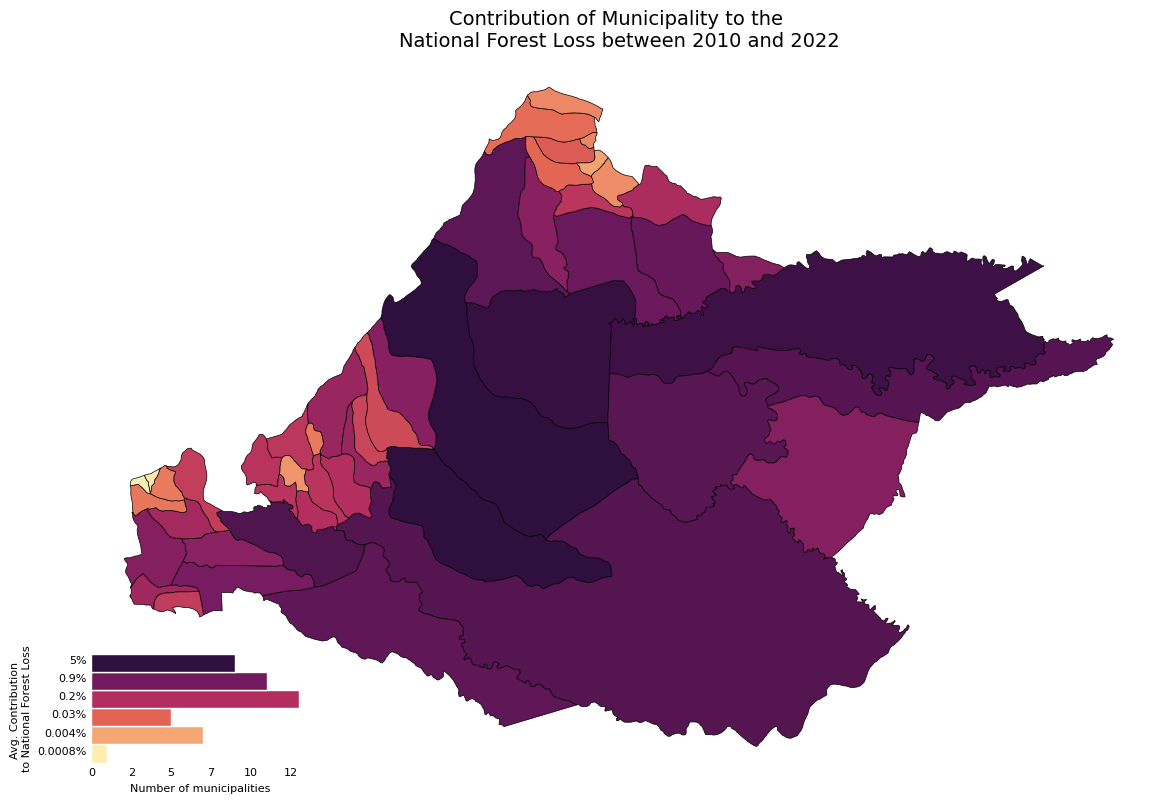

In [731]:
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from palettable.cmocean.sequential import Matter_6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define log scale normalization (1st and 99th percentiles)
vmin = np.percentile(transition_df["contribution_f"].dropna(), 1)
vmax = np.percentile(transition_df["contribution_f"].dropna(), 99)
# vmin = gdf["pc_loss"].min()
# vmax = gdf["pc_loss"].max()
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

##########################################################
### Create Figure and Main Ax for the Map (No Colorbar) ###
##########################################################

fig, ax_map = plt.subplots(figsize=(12, 8))

# Plot the municipalities with NO default legend
transition_df.plot(
    column="contribution_f",
    cmap=Matter_6.mpl_colormap,
    linewidth=0.5,
    edgecolor="black",
    legend=False,  # Turn off default legend
    norm=log_norm,
    ax=ax_map,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

# Title/annotation on the map
ax_map.set_title("Contribution of Municipality to the \nNational Forest Loss between 2010 and 2022", fontsize=14)
ax_map.axis("off")

##################################################
### Create an Inset Axis for the Horizontal Legend
##################################################

# Inset axes inside the main map axis
hist_ax = inset_axes(
    ax_map,
    width="20%",       # Set width as a fraction of the main ax_map width
    height="15%",      # Set height as a fraction of the main ax_map height
    loc="lower left",  # e.g. 'upper right', 'lower right', etc.
    borderpad=1.2      # Distance from the edges of the map
)

# Histogram data and binning
values = transition_df["contribution_f"].dropna()
num_bins = 6
bin_edges = np.logspace(np.log10(vmin), np.log10(vmax), num_bins + 1)
counts, _ = np.histogram(values, bins=bin_edges)

# Plot each bin as a horizontal bar in the inset axis
for i in range(num_bins):
    lower_edge = bin_edges[i]
    upper_edge = bin_edges[i + 1]
    height = upper_edge - lower_edge
    
    hist_ax.barh(
        y=lower_edge,        # vertical position
        width=counts[i],     # horizontal length
        height=height,       # thickness of the bar
        color=Matter_6.hex_colors[i],
        edgecolor="white",
        align="edge"
    )

# Logarithmic scale on the y-axis
hist_ax.set_yscale("log")
hist_ax.set_ylim(bin_edges[0], bin_edges[-1])

# Remove spines
for spine in hist_ax.spines.values():
    spine.set_visible(False)

# Place y-ticks at bin centers
tick_positions = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

# Custom function to format tick labels
def format_tick_label(x):
    if x >= 1:
        return f"{x:.0f}%"
    elif x >= 0.1:
        return f"{x:.1f}%"
    elif x >= 0.01:
        return f"{x:.2f}%"
    elif x >= 0.001:
        return f"{x:.3f}%"
    else:
        return f"{x:.4f}%"

tick_labels = [format_tick_label(tp) for tp in tick_positions]
hist_ax.set_yticks(tick_positions)
hist_ax.set_yticklabels(tick_labels, fontsize=8)

hist_ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, pos: f"{int(x)}")
)

hist_ax.set_xlabel("Number of municipalities", fontsize=8)
hist_ax.set_ylabel("Avg. Contribution \nto National Forest Loss", fontsize=8)
#hist_ax.set_title("Distribution of Forest Loss", fontsize=10)

# Optional: remove or reduce tick mark length
hist_ax.tick_params(axis="both", which="both", length=0, labelsize=8)

# Tweak layout
plt.tight_layout()
plt.show()


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\1496997624.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


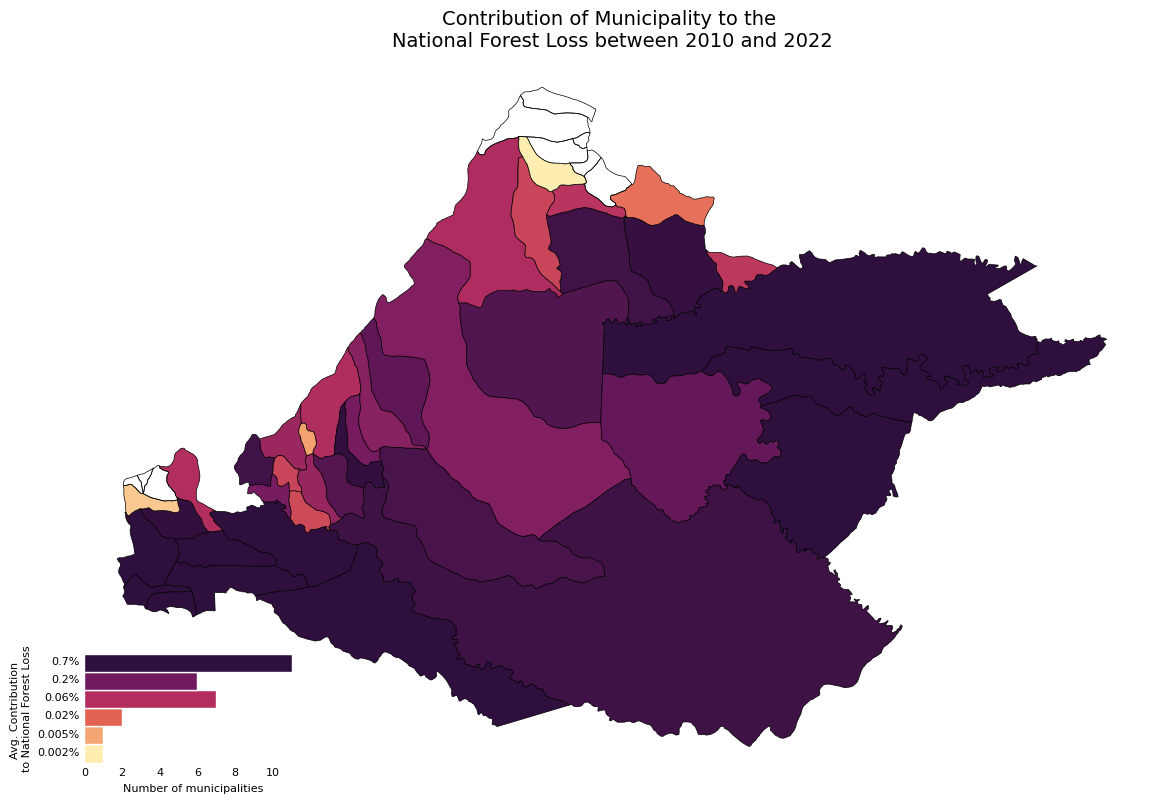

In [732]:
# Define log scale normalization (1st and 99th percentiles)
vmin = np.percentile(transition_df["contribution_c"].dropna(), 20)
vmax = np.percentile(transition_df["contribution_c"].dropna(), 80)
# vmin = transition_df["contribution_c"].min()
# vmax = transition_df["contribution_c"].max()
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

##########################################################
### Create Figure and Main Ax for the Map (No Colorbar) ###
##########################################################

fig, ax_map = plt.subplots(figsize=(12, 8))

# Plot the municipalities with NO default legend
transition_df.plot(
    column="contribution_c",
    cmap=Matter_6.mpl_colormap,
    linewidth=0.5,
    edgecolor="black",
    legend=False,  # Turn off default legend
    norm=log_norm,
    ax=ax_map,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

# Title/annotation on the map
ax_map.set_title("Contribution of Municipality to the \nNational Forest Loss between 2010 and 2022", fontsize=14)
ax_map.axis("off")

##################################################
### Create an Inset Axis for the Horizontal Legend
##################################################

# Inset axes inside the main map axis
hist_ax = inset_axes(
    ax_map,
    width="20%",       # Set width as a fraction of the main ax_map width
    height="15%",      # Set height as a fraction of the main ax_map height
    loc="lower left",  # e.g. 'upper right', 'lower right', etc.
    borderpad=1.2      # Distance from the edges of the map
)

# Histogram data and binning
values = transition_df["contribution_c"].dropna()
num_bins = 6
bin_edges = np.logspace(np.log10(vmin), np.log10(vmax), num_bins + 1)
counts, _ = np.histogram(values, bins=bin_edges)

# Plot each bin as a horizontal bar in the inset axis
for i in range(num_bins):
    lower_edge = bin_edges[i]
    upper_edge = bin_edges[i + 1]
    height = upper_edge - lower_edge
    
    hist_ax.barh(
        y=lower_edge,        # vertical position
        width=counts[i],     # horizontal length
        height=height,       # thickness of the bar
        color=Matter_6.hex_colors[i],
        edgecolor="white",
        align="edge"
    )

# Logarithmic scale on the y-axis
hist_ax.set_yscale("log")
hist_ax.set_ylim(bin_edges[0], bin_edges[-1])

# Remove spines
for spine in hist_ax.spines.values():
    spine.set_visible(False)

# Place y-ticks at bin centers
tick_positions = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

# Custom function to format tick labels
def format_tick_label(x):
    if x >= 1:
        return f"{x:.0f}%"
    elif x >= 0.1:
        return f"{x:.1f}%"
    elif x >= 0.01:
        return f"{x:.2f}%"
    elif x >= 0.001:
        return f"{x:.3f}%"
    else:
        return f"{x:.4f}%"

tick_labels = [format_tick_label(tp) for tp in tick_positions]
hist_ax.set_yticks(tick_positions)
hist_ax.set_yticklabels(tick_labels, fontsize=8)

hist_ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, pos: f"{int(x)}")
)

hist_ax.set_xlabel("Number of municipalities", fontsize=8)
hist_ax.set_ylabel("Avg. Contribution \nto National Forest Loss", fontsize=8)
#hist_ax.set_title("Distribution of Forest Loss", fontsize=10)

# Optional: remove or reduce tick mark length
hist_ax.tick_params(axis="both", which="both", length=0, labelsize=8)

# Tweak layout
plt.tight_layout()
plt.show()


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\270583308.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


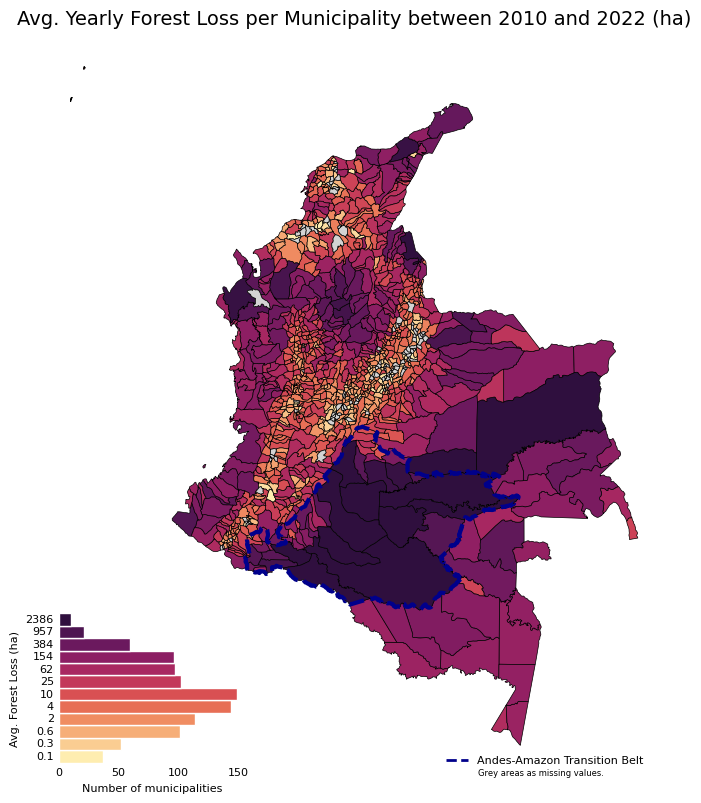

In [733]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.lines as mlines

from palettable.cmocean.sequential import Matter_12
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

######################################
### Aggregate Tree Cover Loss Data ###
######################################

# Aggregate Tree Cover Loss by Municipality
avg_f_loss = final_df.groupby("codmpio")["f_loss"].mean().reset_index()

# Merge Data and Ensure Geometry is Valid
gdf = shapes.merge(avg_f_loss, on="codmpio", how="left")
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")
gdf = gdf.dropna(subset=["geometry"])
gdf = gdf[gdf.is_valid]  # Remove invalid geometries

# Replace 0 with NaN to avoid issues with logarithms
gdf["f_loss"] = gdf["f_loss"].replace(0, np.nan)

# Define log scale normalization (1st and 99th percentiles)
vmin = np.percentile(gdf["f_loss"].dropna(), 1)
vmax = np.percentile(gdf["f_loss"].dropna(), 99)
# vmin = gdf["pc_loss"].min()
# vmax = gdf["pc_loss"].max()
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

##########################################################
### Create Figure and Main Ax for the Map (No Colorbar) ###
##########################################################

fig, ax_map = plt.subplots(figsize=(12, 8))

# Plot your boundary (if applicable)
transition.boundary.plot(ax=ax_map, linewidth=3, color="darkblue", linestyle="--")

# Plot the municipalities with NO default legend
gdf.plot(
    column="f_loss",
    cmap=Matter_12.mpl_colormap,
    linewidth=0.5,
    edgecolor="black",
    legend=False,  # Turn off default legend
    norm=log_norm,
    ax=ax_map,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

# Title/annotation on the map
ax_map.set_title("Avg. Yearly Forest Loss per Municipality between 2010 and 2022 (ha)", fontsize=14)
ax_map.axis("off")

##################################################
### Create an Inset Axis for the Horizontal Legend
##################################################

# Inset axes inside the main map axis
hist_ax = inset_axes(
    ax_map,
    width="30%",       # Set width as a fraction of the main ax_map width
    height="20%",      # Set height as a fraction of the main ax_map height
    loc="lower left",  # e.g. 'upper right', 'lower right', etc.
    borderpad=1.2      # Distance from the edges of the map
)

# Histogram data and binning
values = gdf["f_loss"].dropna()
num_bins = 12
bin_edges = np.logspace(np.log10(vmin), np.log10(vmax), num_bins + 1)
counts, _ = np.histogram(values, bins=bin_edges)

# Plot each bin as a horizontal bar in the inset axis
for i in range(num_bins):
    lower_edge = bin_edges[i]
    upper_edge = bin_edges[i + 1]
    height = upper_edge - lower_edge
    
    hist_ax.barh(
        y=lower_edge,        # vertical position
        width=counts[i],     # horizontal length
        height=height,       # thickness of the bar
        color=Matter_12.hex_colors[i],
        edgecolor="white",
        align="edge"
    )

# Logarithmic scale on the y-axis
hist_ax.set_yscale("log")
hist_ax.set_ylim(bin_edges[0], bin_edges[-1])

# Remove spines
for spine in hist_ax.spines.values():
    spine.set_visible(False)

# Place y-ticks at bin centers
tick_positions = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

# Custom function to format tick labels
def format_tick_label(x):
    if x >= 1:
        return f"{x:.0f}"
    elif x >= 0.1:
        return f"{x:.1f}"
    elif x >= 0.01:
        return f"{x:.2f}"
    elif x >= 0.001:
        return f"{x:.3f}"
    else:
        return f"{x:.4f}"

tick_labels = [format_tick_label(tp) for tp in tick_positions]
hist_ax.set_yticks(tick_positions)
hist_ax.set_yticklabels(tick_labels, fontsize=8)

hist_ax.set_xlabel("Number of municipalities", fontsize=8)
hist_ax.set_ylabel("Avg. Forest Loss (ha)", fontsize=8)
#hist_ax.set_title("Distribution of Forest Loss", fontsize=10)

# Optional: remove or reduce tick mark length
hist_ax.tick_params(axis="both", which="both", length=0, labelsize=8)

# Instead of annotating the map, create a custom legend handle.
transition_handle = mlines.Line2D([], [], color="darkblue", linestyle="--", linewidth=2,
                                    label="Andes-Amazon Transition Belt")

# Add the handle to the map's legend in the bottom right corner.
# Here, the legend is created solely for the transition belt.
ax_map.legend(handles=[transition_handle], loc="lower right", fontsize=8, title_fontsize=12, frameon=False,
              title="", bbox_to_anchor=(0.98, 0.005))
ax_map.annotate("Grey areas as missing values.", xy=(0.8, 0.005), xycoords="axes fraction",
            ha="center", fontsize=6, color="black", bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"))  

# Tweak layout
plt.tight_layout()
plt.show()



C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\1605312323.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid
C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\1605312323.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["x"] = gdf.centroid.x
C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\1605312323.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["y"] = gdf.centroid.y
c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Wind

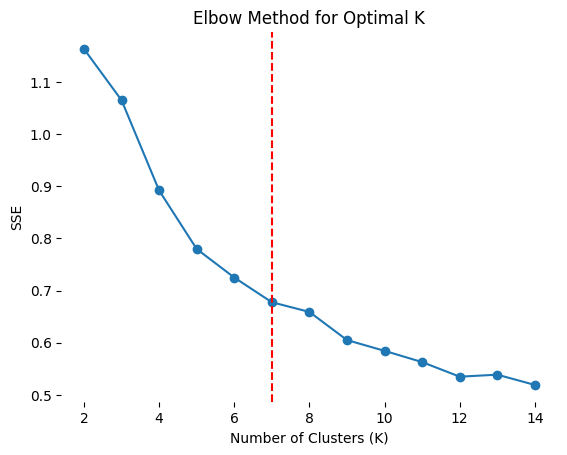

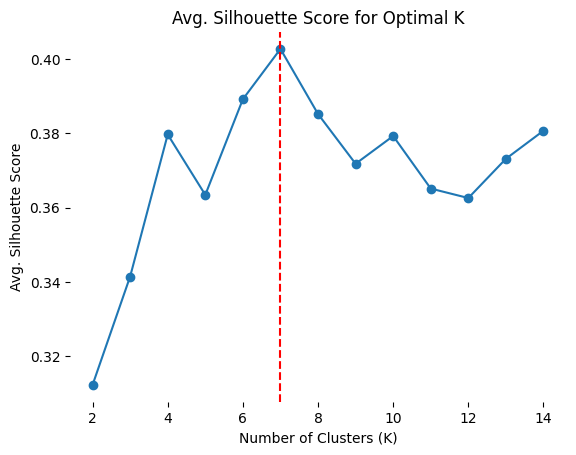

C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\1605312323.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


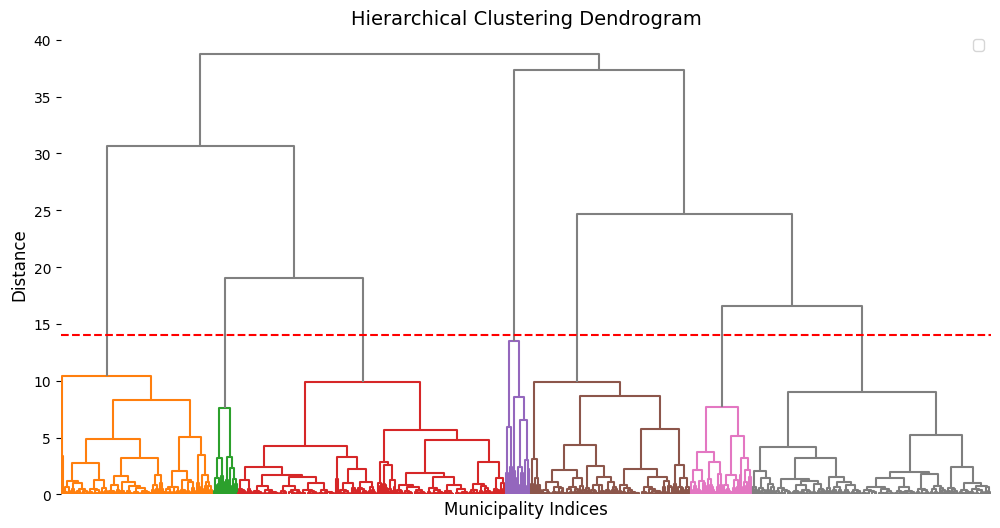

c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [734]:
######################
### Clustering 2.0 ### --------------> ESTE FUNCIONA MEJOR
######################
from turtle import color


os.environ["OMP_NUM_THREADS"] = "5"


# Pivot the data so each row is a municipality and each column is a year
deforestation_wide = final_df.pivot(index=["codmpio", 'geometry'], columns="year", values="pc_loss").fillna(0)

# Compute the average deforestation per municipality across all years
deforestation_wide["avg_deforestation"] = deforestation_wide.mean(axis=1)

# Select only the relevant columns (municipality, geometry, avg_deforestation)
deforestation_avg = deforestation_wide[["avg_deforestation"]].reset_index()

# Merge with the municipality geometries
gdf = shapes.merge(deforestation_avg, on="codmpio", how="left")

# Ensure No NaNs Before Clustering
gdf["avg_deforestation"] = gdf["avg_deforestation"].fillna(0)

# Convert to GeoDataFrame (Ensure it's recognized as a GeoDataFrame)
gdf = gpd.GeoDataFrame(gdf, geometry="geometry_x")

# Extract Centroids (Spatial Features)
gdf["centroid"] = gdf.geometry.centroid
gdf["x"] = gdf.centroid.x
gdf["y"] = gdf.centroid.y

# ✅ Select Features for Clustering (Spatial + Avg Deforestation)
features = gdf[["x", "y", "avg_deforestation"]].values

# Normalize Features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

######################
### Find Optimal K ###
######################

distortions = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_features)
    
    # Compute Distortion (Elbow Method)
    distortions.append(sum(np.min(cdist(normalized_features, kmeans.cluster_centers_, 'euclidean'), axis=1)) / normalized_features.shape[0])
    
    # Compute Silhouette Score
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(normalized_features, labels))

# Plot the Elbow Curve
plt.plot(K_range, distortions, marker="o")
plt.axvline(x=7, color='r', linestyle='--', label="Optimal K = 7")  # Add vertical line
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal K")

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

    
# Plot Silhouette Score
plt.plot(K_range, silhouette_scores, marker="o")
plt.axvline(x=7, color='r', linestyle='--', label="Optimal K = 7")  # Add vertical line
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Avg. Silhouette Score")
plt.title("Avg. Silhouette Score for Optimal K")

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()


###############################
### Hierarchical Clustering ###
###############################

# Compute the linkage matrix
linkage_matrix = linkage(normalized_features, method="ward")




# Plot the dendrogram
fig, ax = plt.subplots(figsize=(12, 6))
ddata = dendrogram(
    linkage_matrix,
    ax=ax,
    no_labels=True,  # Removes individual labels (avoid clutter)
    color_threshold=14,  # Colors branches below y=14 differently
    above_threshold_color='gray'    
)

# Add a horizontal line at y=14 to indicate clustering threshold
ax.axhline(y=14, color='r', linestyle='--')

# Improve x-axis: Reduce clutter by using a subset of indices
ax.set_xticks([])  # Hide x-axis labels since too many municipalities cause clutter

# Titles and labels
ax.set_title("Hierarchical Clustering Dendrogram", fontsize=14)
ax.set_xlabel("Municipality Indices", fontsize=12)
ax.set_ylabel("Distance", fontsize=12)

# Show legend
ax.legend()
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

# Apply K-Means Clustering (Choose the best K)
optimal_k = 7   # Adjust based on elbow method result
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
gdf["cluster_kmeans"] = kmeans.fit_predict(normalized_features)
gdf_clusters = gdf.copy()


# 3. Final merging dataset

In [735]:
##############################
### Merging final datasets ###
##############################

# Select gdf columns
gdf = gdf[["codmpio", "cluster_kmeans"]]

# Merge gdf with final_df
final_merge = gdf.merge(final_df, on="codmpio", how="left")

# Sort the dataset by `codmpio` and `year`
final_merge = final_merge.sort_values(by=["codmpio", "year"]).reset_index(drop=True)
del final_merge["geometry"]
final_merge

,codmpio,cluster_kmeans,Departamento,Municipio,Region,year,f_loss,pc_loss,areaoficialhm2,gdp,...,P-01-25,PCC-01-2,PCC-02-1,C-03-14,PCC-02-3,PCC-02-3a,PCC-02-4,C-03-13,P-01-46,P-01-34-1
0,5001,2,ANTIOQUIA,MEDELLIN,Andina,2010.0,30.154418,0.077918,38700.0,2.964083e+07,...,1.0,45.165549,100.0,12.590432,99.751839,100.000000,50.000000,1.0,1.217692,4.0
1,5001,2,ANTIOQUIA,MEDELLIN,Andina,2011.0,25.695615,0.066397,38700.0,3.444253e+07,...,1.0,45.245880,100.0,12.920759,99.751839,100.000000,50.000000,1.0,1.217692,4.0
2,5001,2,ANTIOQUIA,MEDELLIN,Andina,2012.0,29.345245,0.075828,38700.0,3.692472e+07,...,1.0,46.737400,100.0,11.617163,99.751839,100.000000,50.000000,1.0,1.217692,4.0
3,5001,2,ANTIOQUIA,MEDELLIN,Andina,2013.0,18.412226,0.047577,38700.0,4.088087e+07,...,1.0,50.976367,100.0,12.658621,99.751839,100.000000,50.000000,1.0,1.217692,4.0
4,5001,2,ANTIOQUIA,MEDELLIN,Andina,2014.0,43.509827,0.112428,38700.0,4.304234e+07,...,1.0,49.602144,100.0,11.879778,89.775347,90.355662,45.177831,1.0,1.217692,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14707,99773,3,VICHADA,CUMARIBO,Orinoquia,2018.0,5986.956176,0.091162,6567400.0,2.728310e+05,...,5.0,0.001109,0.0,0.000000,0.185979,1.158266,40.105233,1.0,3.078961,1.0
14708,99773,3,VICHADA,CUMARIBO,Orinoquia,2019.0,5318.000000,0.080976,6567400.0,2.756950e+05,...,5.0,0.001075,0.0,2.469746,0.091892,0.450848,29.522425,1.0,3.078961,1.0
14709,99773,3,VICHADA,CUMARIBO,Orinoquia,2020.0,3986.000000,0.060694,6567400.0,2.766593e+05,...,5.0,0.001052,0.0,2.412022,0.117194,0.502259,29.548131,1.0,3.078961,1.0
14710,99773,3,VICHADA,CUMARIBO,Orinoquia,2021.0,3702.330583,0.056374,6567400.0,3.169662e+05,...,5.0,0.001125,0.0,0.000000,0.136256,0.458311,20.455470,1.0,3.078961,1.0


In [736]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Save the DataFrame as a CSV file
final_merge.to_csv(csv_filename, index=False)

# Compress the CSV file into a ZIP archive
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_filename)

# Delete the original CSV file after zipping
os.remove(csv_filename)

# 3.1. Additional imputation

In [737]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

final_df

,codmpio,cluster_kmeans,Departamento,Municipio,Region,year,f_loss,pc_loss,areaoficialhm2,gdp,...,P-01-25,PCC-01-2,PCC-02-1,C-03-14,PCC-02-3,PCC-02-3a,PCC-02-4,C-03-13,P-01-46,P-01-34-1
0,5001,2,ANTIOQUIA,MEDELLIN,Andina,2010.0,30.154418,0.077918,38700.0,2.964083e+07,...,1.0,45.165549,100.0,12.590432,99.751839,100.000000,50.000000,1.0,1.217692,4.0
1,5001,2,ANTIOQUIA,MEDELLIN,Andina,2011.0,25.695615,0.066397,38700.0,3.444253e+07,...,1.0,45.245880,100.0,12.920759,99.751839,100.000000,50.000000,1.0,1.217692,4.0
2,5001,2,ANTIOQUIA,MEDELLIN,Andina,2012.0,29.345245,0.075828,38700.0,3.692472e+07,...,1.0,46.737400,100.0,11.617163,99.751839,100.000000,50.000000,1.0,1.217692,4.0
3,5001,2,ANTIOQUIA,MEDELLIN,Andina,2013.0,18.412226,0.047577,38700.0,4.088087e+07,...,1.0,50.976367,100.0,12.658621,99.751839,100.000000,50.000000,1.0,1.217692,4.0
4,5001,2,ANTIOQUIA,MEDELLIN,Andina,2014.0,43.509827,0.112428,38700.0,4.304234e+07,...,1.0,49.602144,100.0,11.879778,89.775347,90.355662,45.177831,1.0,1.217692,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14707,99773,3,VICHADA,CUMARIBO,Orinoquia,2018.0,5986.956176,0.091162,6567400.0,2.728310e+05,...,5.0,0.001109,0.0,0.000000,0.185979,1.158266,40.105233,1.0,3.078961,1.0
14708,99773,3,VICHADA,CUMARIBO,Orinoquia,2019.0,5318.000000,0.080976,6567400.0,2.756950e+05,...,5.0,0.001075,0.0,2.469746,0.091892,0.450848,29.522425,1.0,3.078961,1.0
14709,99773,3,VICHADA,CUMARIBO,Orinoquia,2020.0,3986.000000,0.060694,6567400.0,2.766593e+05,...,5.0,0.001052,0.0,2.412022,0.117194,0.502259,29.548131,1.0,3.078961,1.0
14710,99773,3,VICHADA,CUMARIBO,Orinoquia,2021.0,3702.330583,0.056374,6567400.0,3.169662e+05,...,5.0,0.001125,0.0,0.000000,0.136256,0.458311,20.455470,1.0,3.078961,1.0


In [738]:
# Get rid of rows with all NaN values
final_df = final_df[~final_df[final_df.columns[2:]].isna().all(axis=1)]


In [739]:
# Calculate % of missing values per column
na_percent = final_df.isna().mean() * 100

# Filter only columns with missing values
na_summary = na_percent[na_percent > 0].sort_values(ascending=False).reset_index()
na_summary.columns = ['Variable', 'Percentage_NA']

# Round for cleaner display
na_summary['Percentage_NA'] = na_summary['Percentage_NA'].round(2)

na_summary


,Variable,Percentage_NA
0,M-03-24,47.41
1,dismdo,30.75
2,CV-03-64,15.76
3,CV-02-12e,15.38
4,CV-03-26,12.96
5,CV-03-26b,12.96
6,CV-03-27,7.99
7,CTI-01-3,4.82
8,CV-03-65Aj,3.80
9,PCC-02-1,3.32


In [740]:
final_df = final_df[-final_df['year'].isna()]

# Fill NAs with 0 for cases with 0 events
group_zero_cols = ["eventos_minas", "e_vinc_mened", "e_tortura", "e_minas_anti", "e_desplaza", "e_desap_for", "e_confina",
                   "e_amenaza", "pirateria_terr", "terrorismot", "errad_manual", "H_coca", "e_delito_sex", "C-02-8t",
                   "total_ac", "total_as", "total_p", "total_r", "total_nuf", "total_vrf", "M-03-24"]

for col in group_zero_cols:
    final_df[col] = final_df[col].fillna(0)

# Fill first using interpolation, then departmental mean, then national median
group_inter_cols = [var for var in na_summary['Variable'] if var not in group_zero_cols]

for col in group_inter_cols:
    # Step 1: Interpolate by municipality
    col_interp = final_df.groupby("codmpio")[col].transform(lambda x: x.interpolate().ffill().bfill())

    # Step 2: Validity checks at department level
    total_munis = final_df.groupby("Departamento")["codmpio"].nunique()
    valid_munis = final_df[~col_interp.isna()].groupby("Departamento")["codmpio"].nunique()
    prop_valid = (valid_munis / total_munis).fillna(0)
    depts_ok = prop_valid[prop_valid >= 0.5].index

    # Step 3: Department mean (only for good departments)
    dept_mean = final_df.groupby("Departamento")[col].transform("mean")
    use_dept_mean = final_df["Departamento"].isin(depts_ok)

    # Step 4: Fill with department mean
    col_filled = col_interp.where(~col_interp.isna(), other=np.where(use_dept_mean, dept_mean, np.nan))

    # Step 5: Fill with regional value if still missing
    # You can choose mean or median here
    regional_stat = final_df.groupby("Region")[col].transform("median")  # or "mean"
    col_filled = col_filled.fillna(regional_stat)

    # Step 6: Final fallback → national median
    final_df[col] = col_filled.fillna(final_df[col].median())


In [741]:
final_df.isna().sum().sum()

0

In [743]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Save the DataFrame as a CSV file
final_df.to_csv(csv_filename, index=False)

# Compress the CSV file into a ZIP archive
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_filename)

# Delete the original CSV file after zipping
os.remove(csv_filename)

# 4. Additional graphs for visualization

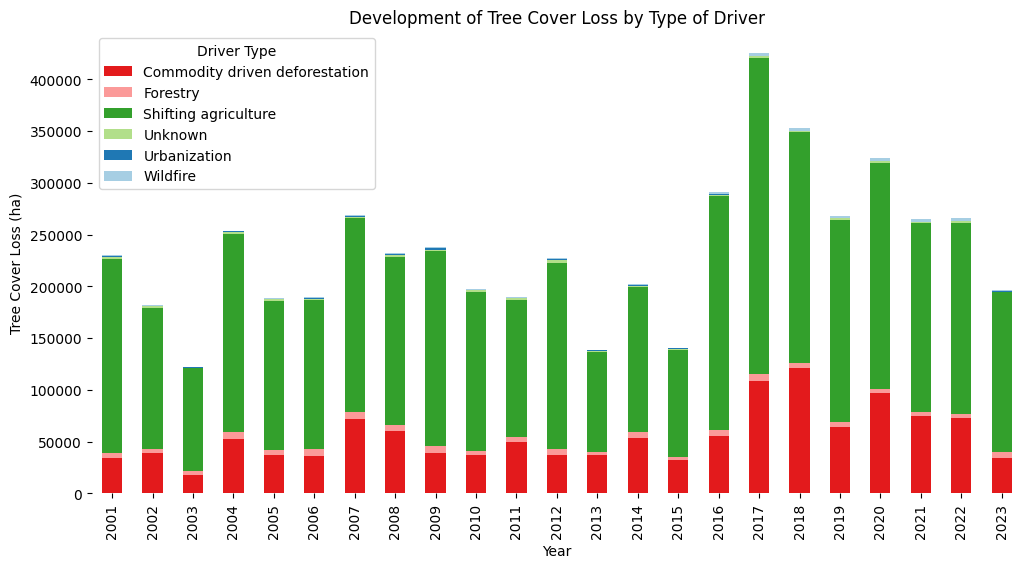

In [5]:
#######################################
### Deforestation by type of driver ###
#######################################
from palettable.colorbrewer.qualitative import Paired_6_r
# Define colors from Balance_6
colors = Paired_6_r.hex_colors

# Deforestation data by type of driver
df_deforestation = dataframes[3]

# Pivot the dataframe to have years as index and types as columns
df_pivot = df_deforestation.pivot(index='umd_tree_cover_loss__year', columns='tsc_tree_cover_loss_drivers__driver', values='umd_tree_cover_loss__ha')

# Plot the bar graph
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot.plot(kind='bar', stacked=True, ax=ax, color=colors)

# Remove spines from the axes for a cleaner look
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Development of Tree Cover Loss by Type of Driver')
plt.xlabel('Year')
plt.ylabel('Tree Cover Loss (ha)')
plt.legend(title='Driver Type')
plt.show()

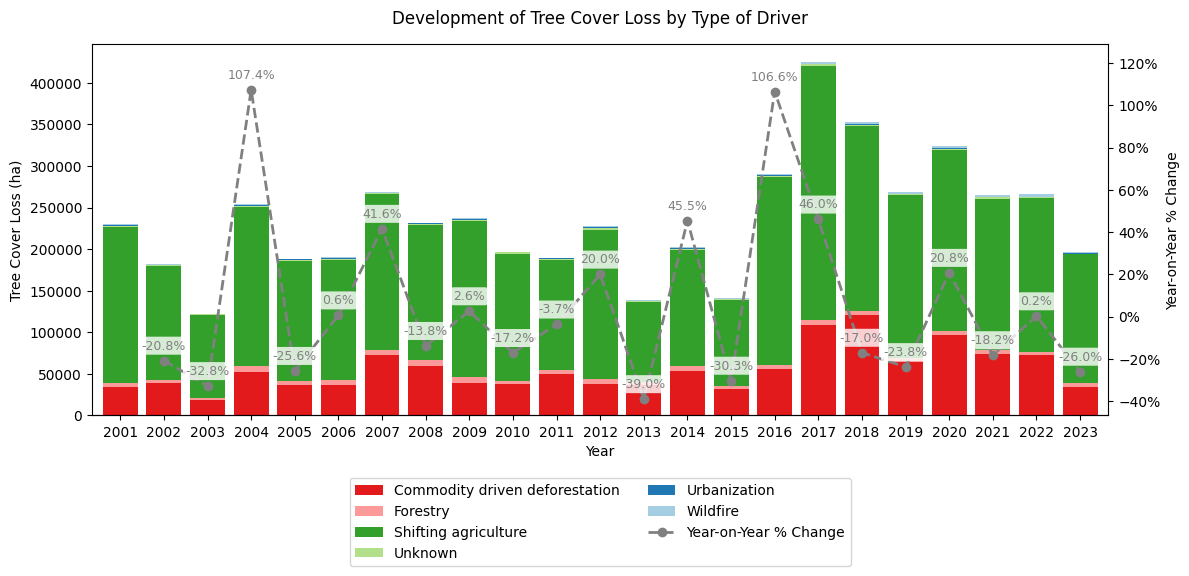

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from palettable.colorbrewer.qualitative import Paired_6_r

# … your existing code to build df_pivot …

# 1. Compute totals & pct‐change
total_loss = df_pivot.sum(axis=1)
pct_change = total_loss.pct_change() * 100

# 2. Plot stacked bars
fig, ax = plt.subplots(figsize=(12, 6))
df_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=Paired_6_r.hex_colors,
    width=0.8,
    edgecolor='none'
)

# 3. Clean up left axis
for spine in ('top', 'right', 'left',):
    ax.spines[spine].set_visible(False)
ax.set_title('Development of Tree Cover Loss by Type of Driver', pad=15)
ax.set_xlabel('Year')
ax.set_ylabel('Tree Cover Loss (ha)')
ax.legend(title='Driver Type', loc='upper left')

# 4. Secondary axis for % change
ax2 = ax.twinx()
x = np.arange(len(df_pivot.index))
line, = ax2.plot(
    x, pct_change.values,
    linestyle='--',
    marker='o',
    color='grey',
    linewidth=2,
    markersize=6,
    zorder=3,
    label='Year-on-Year % Change'
)
ax2.set_ylabel('Year-on-Year % Change')
# Format right axis as %
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
# Give it a little headroom
ymin, ymax = pct_change.min(), pct_change.max()
ax2.set_ylim(ymin * 1.2, ymax * 1.2)

# 5. Annotate each marker
for i, pct in enumerate(pct_change):
    if not np.isnan(pct):
        ax2.annotate(
            f'{pct:.1f}%',
            (i, pct),
            textcoords="offset points",
            xytext=(0, 6),
            ha='center',
            va='bottom',
            fontsize=9,
            color='grey',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
        )

# 6. Tidy x-ticks
ax.set_xticks(x)
ax.set_xticklabels(df_pivot.index.astype(str), rotation=0)

# 7. Merge legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = [line], ['Year-on-Year % Change']
ax.legend(
    handles1 + handles2,
    labels1 + labels2,
    title='',
    ncol=2,
    bbox_to_anchor=(0.5, -0.15),
    loc='upper center'
)

plt.tight_layout()
plt.show()



In [745]:
# Calculate the total tree cover loss by year
df_pivot['Total'] = df_pivot.sum(axis=1)

# Calculate the percentage of "Shifting agriculture" for each year
df_pivot['Shifting_agriculture_percentage'] = (df_pivot['Shifting agriculture'] / df_pivot['Total']) * 100

# Calculate the average percentage of "Shifting agriculture"
average_shifting_agriculture_percentage = df_pivot['Shifting_agriculture_percentage'].mean()

print(f"Average percentage of Shifting agriculture: {average_shifting_agriculture_percentage:.2f}%")

Average percentage of Shifting agriculture: 73.50%


In [39]:
missing = shapes[shapes["codmpio"] == 27086]
missing["Region"] = "Pacifica"
missing["depto"] = "Chocó"

c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


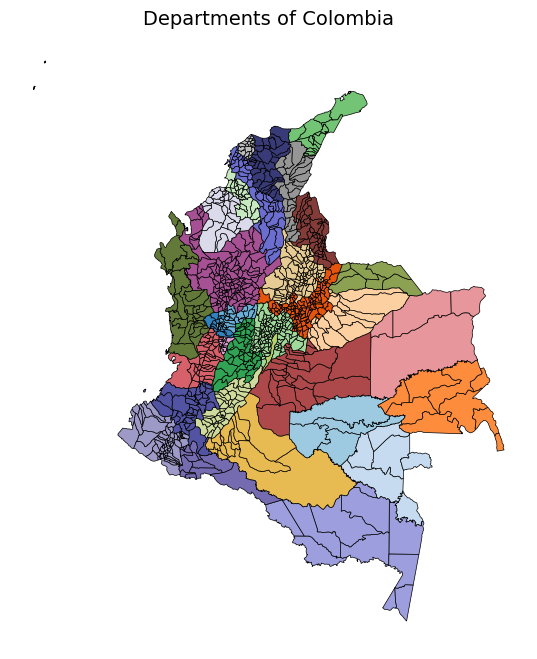

In [747]:
# Map for departments --------------> DE PRONTO NO CONVIENE POR LA CANTIDAD DE DEPARTAMENTOS

# Set a fixed seed to ensure the same colors are selected every time
random.seed(123)

# Extract 20 colors from 'tab20b' and 'tab20c' (total of 40)
colors_tab20b = [plt.cm.tab20b(i/20) for i in range(20)]
colors_tab20c = [plt.cm.tab20c(i/20) for i in range(20)]

# Combine both color lists
all_colors = colors_tab20b + colors_tab20c  # 40 total colors

# Randomly select 33 unique colors
selected_colors = random.sample(all_colors, 33)

# Convert to a colormap
custom_cmap = ListedColormap(selected_colors)


# Plot the map for regions
fig, ax = plt.subplots(figsize=(12, 8))
gdf_new.plot(column="depto", cmap=custom_cmap, linewidth=0.5, edgecolor="black", legend=False, ax=ax)

# Set title
ax.set_title("Departments of Colombia", fontsize=14)

# Remove axis borders
ax.axis("off")

plt.show()

In [15]:
##############
### Tables ###
##############
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

cluster_table = final_df.groupby("cluster_kmeans").agg(
    avg_pc_loss = ('pc_loss', 'mean'),
    avg_f_loss = ('f_loss', 'mean'),
    total_f_loss = ('f_loss', 'sum'),
    num_municipalities = ('codmpio', 'nunique')
).reset_index()
# Compute overall total f_loss from the entire dataset
overall_f_loss = final_df['f_loss'].sum()

# Create a column for the ratio: total f_loss by cluster divided by overall total f_loss
cluster_table['f_loss_ratio'] = cluster_table['total_f_loss'] / overall_f_loss

# Optionally, drop the raw total_f_loss column if you only need the ratio
cluster_table.drop(columns=['total_f_loss'], inplace=True)

# Multiply by 100 and format avg_pc_loss as percentage with two decimals
cluster_table['avg_pc_loss'] = (cluster_table['avg_pc_loss']).map("{:.2f}%".format)

# Multiply f_loss_ratio by 100 and format it as a percentage with two decimals
cluster_table['pc_f_loss_ratio'] = (cluster_table['f_loss_ratio'] * 100).map("{:.2f}%".format)

# avg_f_loss with two decimals
cluster_table['avg_f_loss'] = cluster_table['avg_f_loss'].map("{:.2f}".format)

# Sort the table by cluster number
cluster_table = cluster_table[['cluster_kmeans', 'num_municipalities', 'avg_pc_loss', 'avg_f_loss', 'f_loss_ratio', 'pc_f_loss_ratio']]	
cluster_table


,cluster_kmeans,num_municipalities,avg_pc_loss,avg_f_loss,f_loss_ratio,pc_f_loss_ratio
0,0,69,0.32%,530.26,0.216010,21.60%
1,1,20,1.00%,3702.02,0.437124,43.71%
2,2,312,0.03%,17.99,0.033141,3.31%
3,3,32,0.05%,695.61,0.129522,12.95%
4,4,180,0.04%,30.21,0.032107,3.21%
5,5,338,0.03%,25.21,0.051355,5.14%
6,6,167,0.07%,98.07,0.100740,10.07%


NameError: name 'gdf_clusters' is not defined

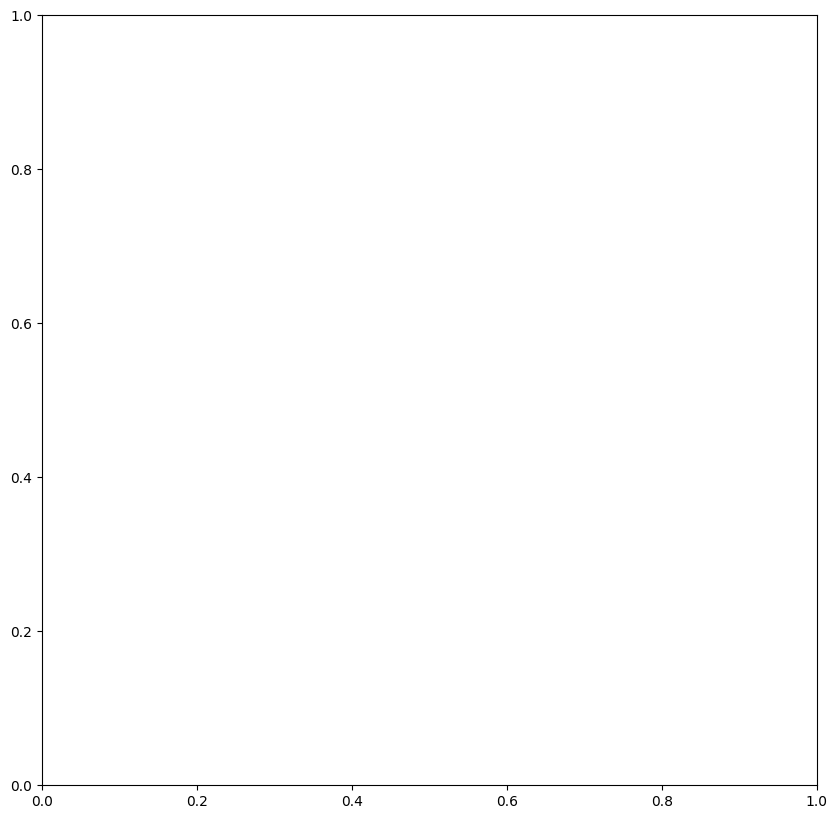

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
from palettable.cmocean.sequential import Matter_7_r
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assume gdf_clusters, final_df, shapes, transition, and cluster_table are predefined

desired_order = [1, 0, 3, 6, 5, 2, 4]  # Replace with your actual order
ordered_clusters = desired_order
colors = Matter_7_r.hex_colors  # 7 colors from the reversed palette
custom_cmap = ListedColormap(colors)

# Plot the main map
fig, ax = plt.subplots(figsize=(10, 10))

# Ensure cluster column is categorical with desired order
gdf_clusters["cluster_kmeans"] = pd.Categorical(gdf_clusters["cluster_kmeans"],
                                                categories=ordered_clusters,
                                                ordered=True)
gdf_clusters.plot(column="cluster_kmeans", cmap=custom_cmap, linewidth=0.5,
                  edgecolor="black", legend=False, ax=ax)

# Add transition boundary
transition.boundary.plot(ax=ax, linewidth=3, color="darkblue", linestyle="--") 

# --- Create Inset Bar Plot in Lower Right Corner --- #
# Prepare data: sort clusters by contribution
cluster_table_numeric = cluster_table.sort_values(by='f_loss_ratio', ascending=False)
cluster_order_in_bar = cluster_table_numeric['cluster_kmeans'].tolist()

# Assign colors based on desired_order
bar_colors = [colors[ordered_clusters.index(cluster)] for cluster in cluster_order_in_bar]

# Create inset axes for the bar plot
bar_ax = inset_axes(
    ax,
    width="30%",        # Adjust width as needed
    height="20%",       # Adjust height as needed
    loc="lower left",  # Position in lower right
    borderpad=1.2
)

# Plot horizontal bars
y_labels = [f"Cluster {c}" for c in cluster_order_in_bar]
x_values = cluster_table_numeric['f_loss_ratio'] * 100  # Convert to %
bars = bar_ax.barh(y_labels, x_values, color=bar_colors, edgecolor='white')

# Format bar plot
bar_ax.invert_yaxis()  # Highest value at top
bar_ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}%"))
bar_ax.set_xlabel('Contribution to National Forest Loss', fontsize=10)


# Add value labels
for bar in bars:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    bar_ax.text(width + 1, y_pos, f"{width:.2f}%", va='center', fontsize=8)

# Remove spines for cleaner look
for spine in bar_ax.spines.values():
    spine.set_visible(False)

# --- Transition Belt Legend --- #
transition_handle = mlines.Line2D([], [], color="darkblue", linestyle="--", linewidth=2,
                                  label="Andes-Amazon Transition Belt")
ax.legend(handles=[transition_handle], loc="lower right", 
          bbox_to_anchor=(0.98, 0.01), fontsize=8, frameon=False)

ax.set_title("K-Means Clustering of Municipalities by contribution to \nNational Forest Loss between 2010 and 2022", fontsize=14)
ax.axis("off")

plt.show()

In [18]:
region_table = final_df.groupby("Region").agg(
    avg_pc_loss = ('pc_loss', 'mean'),
    avg_f_loss = ('f_loss', 'mean'),
    total_f_loss = ('f_loss', 'sum'),
    num_municipalities = ('codmpio', 'nunique')
).reset_index()

# Create a column for the ratio: total f_loss by region divided by overall total f_loss
region_table['f_loss_ratio'] = region_table['total_f_loss'] / overall_f_loss

# Optionally, drop the raw total_f_loss column if you only need the ratio
region_table.drop(columns=['total_f_loss'], inplace=True)

# Multiply by 100 and format avg_pc_loss as percentage with two decimals
region_table['avg_pc_loss'] = (region_table['avg_pc_loss']).map("{:.2f}%".format)

# Multiply f_loss_ratio by 100 and format it as a percentage with two decimals
region_table['pc_f_loss_ratio'] = (region_table['f_loss_ratio'] * 100).map("{:.2f}%".format)

# avg_f_loss with two decimals
region_table['avg_f_loss'] = region_table['avg_f_loss'].map("{:.2f}".format)

# Sort the table by region number
region_table = region_table[['Region', 'num_municipalities', 'avg_pc_loss', 'avg_f_loss', 'f_loss_ratio', 'pc_f_loss_ratio']]
region_table['Region'] = region_table['Region'].replace({'Amazonia': 'Amazon', 
                                                          'Andina': 'Andean', 
                                                          'Caribe': 'Caribbean', 
                                                          'Orinoquia': 'Orinoco',
                                                          'Pacifica': 'Pacific'})
region_table


,Region,num_municipalities,avg_pc_loss,avg_f_loss,f_loss_ratio,pc_f_loss_ratio
0,Amazon,59,0.19%,1265.15,0.437240,43.72%
1,Andean,629,0.05%,44.58,0.167379,16.74%
2,Caribbean,194,0.08%,67.97,0.077844,7.78%
3,Orinoco,59,0.12%,630.06,0.219468,21.95%
4,Pacific,177,0.07%,90.28,0.098069,9.81%


IndexError: index 0 is out of bounds for axis 0 with size 0

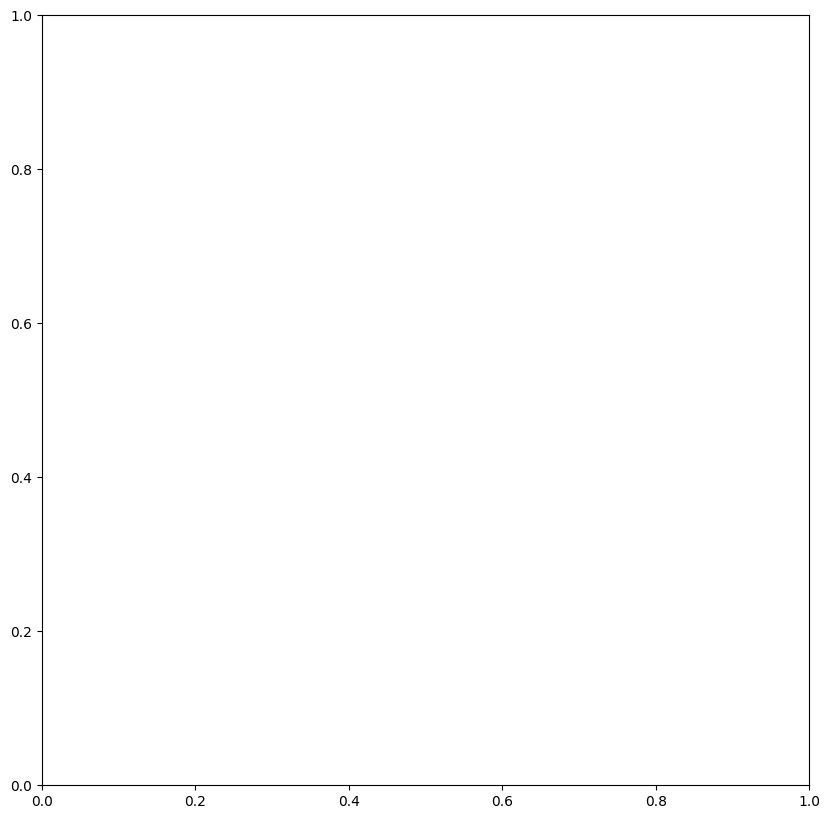

In [40]:
regions = general[["codmpio", "Region"]]
regions = regions.merge(dataframes[5][["codmpio", "depto"]], on= "codmpio")
regions = regions.drop_duplicates(subset = ["codmpio", "Region"])
regions = pd.concat([regions, missing])

gdf_new = shapes.merge(regions, on="codmpio")
del gdf_new["geometry_y"]
gdf_new = gdf_new.rename(columns= {
    "geometry_x": "geometry"
}) 
gdf_new =  gpd.GeoDataFrame(gdf_new, geometry= "geometry")

from palettable.cmocean.sequential import Matter_5_r

# Option 1: Use your known (manual) desired order
gdf_new.plot(column="Region", cmap="Paired", linewidth=0.5, edgecolor="black", legend=True, ax=ax)
desired_order = ['Amazon', 'Orinoco', 'Andean', 'Pacific', 'Caribbean']  # Replace with your actual desired cluster order

# Ensure that the clusters in your data are in the desired order.
# (It is assumed that gdf["cluster_kmeans"] uses integer labels matching those in desired_order.)
ordered_regions = desired_order

####################################
### Build a Custom Colormap      ###
####################################

# Get the Balance_7 hex colors (a list of 7 colors)
colors = Matter_5_r.hex_colors

####################################
### Plot the Map with Clusters   ###
####################################

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the municipalities, using the custom colormap.
# To ensure that the data are mapped into the order you want, set the "categories" manually by
# converting the cluster column to a categorical variable with the proper ordering.
import pandas as pd
gdf_new["Region"] = pd.Categorical(gdf_new["Region"],
                                       categories=ordered_regions,
                                       ordered=True)

gdf_new.plot(column="Region", cmap=custom_cmap, linewidth=0.5,
         edgecolor="black", legend=False, ax=ax)

# Plot the transition boundary (if you have this layer)
transition.boundary.plot(ax=ax, linewidth=3, color="darkblue", linestyle="--") 

# --- Create Inset Bar Plot in Lower Right Corner --- #
# Prepare data: sort regions by contribution
region_table_numeric = region_table.sort_values(by='f_loss_ratio', ascending=False)
region_order_in_bar = region_table_numeric['Region'].tolist()

# Assign colors based on desired_order
bar_colors = [colors[ordered_regions.index(region)] for region in region_order_in_bar]

# Create inset axes for the bar plot
bar_ax = inset_axes(
    ax,
    width="30%",        # Adjust width as needed
    height="20%",       # Adjust height as needed
    loc="lower left",  # Position in lower right
    borderpad=1.2
)

# Plot horizontal bars
y_labels = region_order_in_bar
x_values = region_table_numeric['f_loss_ratio'] * 100  # Convert to %
bars = bar_ax.barh(y_labels, x_values, color=bar_colors, edgecolor='white')

# Format bar plot
bar_ax.invert_yaxis()  # Highest value at top
bar_ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}%"))
bar_ax.set_xlabel('Contribution to National Forest Loss', fontsize=10)


# Add value labels
for bar in bars:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    bar_ax.text(width + 1, y_pos, f"{width:.2f}%", va='center', fontsize=8)

# Remove spines for cleaner look
for spine in bar_ax.spines.values():
    spine.set_visible(False)

####################################
### Create Legend for Transition Belt ###
####################################
# Create a handle for the transition belt.
transition_handle = mlines.Line2D([], [], color="darkblue", linestyle="--", linewidth=2,
                                  label="Andes-Amazon Transition Belt")

# Create a separate legend for the transition belt.
transition_legend = ax.legend(handles=[transition_handle],
                              loc="lower right", fontsize=8, frameon=False,
                              bbox_to_anchor=(0.98, 0.01), title="")


# Set title and add annotation regarding the transition boundary.
ax.set_title("Regions of Colombia by contribution to \nNational Forest Loss between 2010 and 2022", fontsize=14)

# Remove axis borders and display the map.
ax.axis("off")
plt.show()

In [514]:
#####################
### Distance maps ###
#####################

# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")  

# Ensure the 'mpios' column in shapes is of type float to match 'codmpio' in final_df
shapes['codmpio'] = shapes['codmpio'].astype(float)

# Merge the final_df with the shapes dataset
final_shp = shapes.merge(final_df, on='codmpio', how='left')
final_shp = final_shp.drop_duplicates(subset=['geometry'])
final_shp = gpd.GeoDataFrame(final_shp, geometry='geometry')


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\4249405475.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


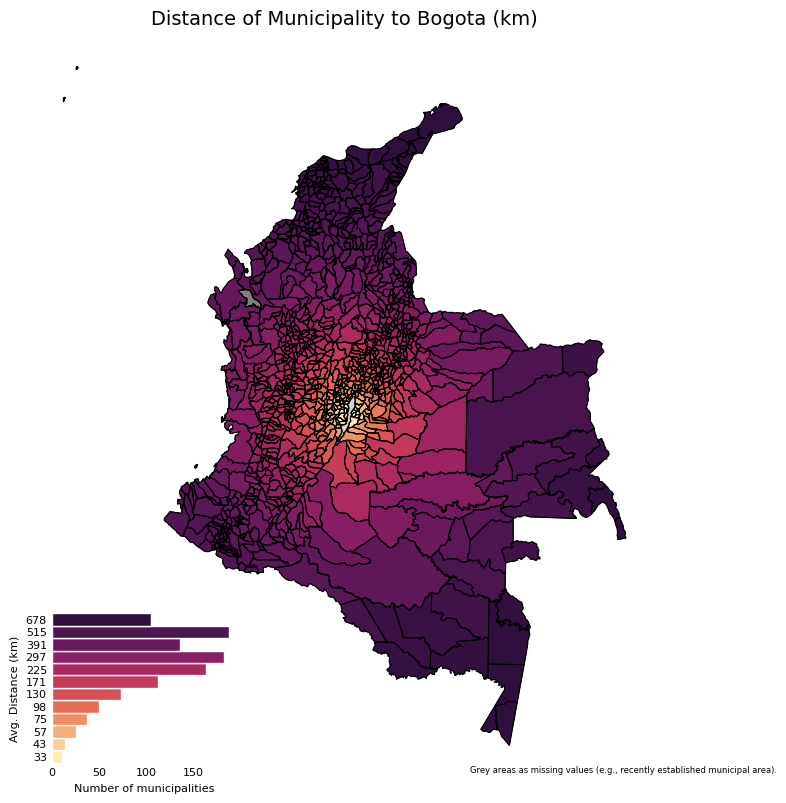

In [524]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# -------------------------------
# Prepare the Distance Map Data
# -------------------------------

# (Assuming you already extracted final_df and final_shp as in your code.)

# Define the log normalization for the color mapping
log_norm = mcolors.LogNorm(
    vmin=np.percentile(final_shp["disbogota"].dropna(), 1), 
    vmax=np.percentile(final_shp["disbogota"].dropna(), 99)
)

# -------------------------------
# Create the Main Map
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all municipalities as light grey outlines
shapes.plot(ax=ax, linewidth=0.8, color="lightgrey")
shapes.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Plot the municipalities colored by their distance to Bogota using the "Reds" colormap.
# Note: We disable the default legend.
final_shp.plot(
    column="disbogota", cmap=Matter_12.mpl_colormap, linewidth=0.5, edgecolor="black",
    norm=log_norm, legend=False, ax=ax,
    missing_kwds={"color": "grey", "label": "No Data"}
)

ax.set_title("Distance of Municipality to Bogota (km)", fontsize=14)
ax.annotate("Grey areas as missing values (e.g., recently established municipal area).", xy=(0.95, 0.01), xycoords="axes fraction",
            ha="center", fontsize=6, color="black", bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"))  
ax.axis("off")  # Remove map axis

# -------------------------------
# Create the Inset Histogram Legend
# -------------------------------

# Create an inset axis at the lower left corner
hist_ax = inset_axes(
    ax,
    width="30%",    # Fraction of the main axis width
    height="20%",   # Fraction of the main axis height
    loc="lower left",
    borderpad=1.2
)

# Use the distance values (disbogota) for the histogram.
values = final_shp["disbogota"]

# Choose the number of bins and create logarithmically spaced bins using the same limits.
num_bins = 12
bin_edges = np.logspace(np.log10(log_norm.vmin), np.log10(log_norm.vmax), num_bins + 1)
counts, _ = np.histogram(values, bins=bin_edges)

# Use the same "Reds" colormap (via matplotlib) for coloring the histogram bins.
cmap = plt.get_cmap("Oranges")

# Plot each bin as a horizontal bar.
for i in range(num_bins):
    lower_edge = bin_edges[i]
    upper_edge = bin_edges[i+1]
    height = upper_edge - lower_edge
    # Pick a color based on the mid-value of the bin; log_norm maps that value to [0,1]
    mid_val = (lower_edge + upper_edge) / 2
    color = Matter_12.hex_colors[i]  # Use the custom color palette
    
    hist_ax.barh(
        y=lower_edge,
        width=counts[i],
        height=height,
        color=color,
        edgecolor="white",
        align="edge"
    )

# Set the y-axis of the inset to logarithmic scale and match the bin range.
hist_ax.set_yscale("log")
hist_ax.set_ylim(bin_edges[0], bin_edges[-1])

# Remove the inset axis spines for a cleaner look.
for spine in hist_ax.spines.values():
    spine.set_visible(False)

# Place y-ticks at the centers of the bins.
tick_positions = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]

# Create a formatter for the y-tick labels (displaying km without a "%" sign)
def format_tick_label(x, pos):
    if x >= 100:
        return f"{x:.0f}"
    elif x >= 10:
        return f"{x:.0f}"
    else:
        return f"{x:.0f}"

hist_ax.set_yticks(tick_positions)
hist_ax.set_yticklabels([format_tick_label(tp, None) for tp in tick_positions], fontsize=8)

# Label inset axes appropriately
hist_ax.set_xlabel("Number of municipalities", fontsize=8)
hist_ax.set_ylabel("Avg. Distance (km)", fontsize=8)
#hist_ax.set_title("Distribution", fontsize=10)
hist_ax.tick_params(axis="both", which="both", length=0, labelsize=8)

# -------------------------------
# Final Layout and Show
# -------------------------------
plt.tight_layout()
plt.show()


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\1292553620.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


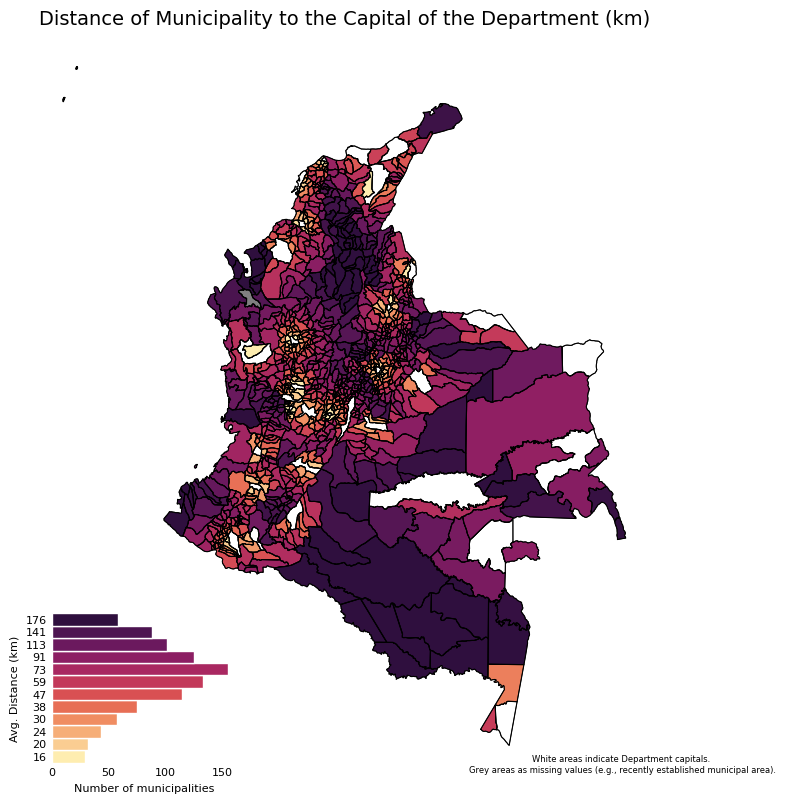

In [523]:
# -------------------------------
# Prepare the Distance Map Data
# -------------------------------

# Replace 0 values in 'discapital' with a small positive number to avoid log(0)
# final_shp["discapital"] = final_shp["discapital"].replace(0, 1e-6)

# Define the log normalization for the color mapping
log_norm = mcolors.LogNorm(
    vmin=np.percentile(final_shp["discapital"].dropna(), 5), 
    vmax=np.percentile(final_shp["discapital"].dropna(), 95)
)

# -------------------------------
# Create the Main Map
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all municipalities as light grey outlines
shapes.plot(ax=ax, linewidth=0.8, color="white")
shapes.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Plot the municipalities colored by their distance to Bogota using the "Reds" colormap.
# Note: We disable the default legend.
final_shp.plot(
    column="discapital", cmap=Matter_12.mpl_colormap, linewidth=0.5, edgecolor="black",
    norm=log_norm, legend=False, ax=ax,
    missing_kwds={"color": "grey", "label": "No Data"}
)

ax.set_title("Distance of Municipality to the Capital of the Department (km)", fontsize=14)
ax.annotate("White areas indicate Department capitals. \nGrey areas as missing values (e.g., recently established municipal area).", xy=(0.95, 0.01), xycoords="axes fraction",
            ha="center", fontsize=6, color="black", bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"))  
ax.axis("off")  # Remove map axis

# -------------------------------
# Create the Inset Histogram Legend
# -------------------------------

# Create an inset axis at the lower left corner
hist_ax = inset_axes(
    ax,
    width="30%",    # Fraction of the main axis width
    height="20%",   # Fraction of the main axis height
    loc="lower left",
    borderpad=1.2
)

# Use the distance values (disbogota) for the histogram.
values = final_shp["discapital"]

# Choose the number of bins and create logarithmically spaced bins using the same limits.
num_bins = 12
bin_edges = np.logspace(np.log10(log_norm.vmin), np.log10(log_norm.vmax), num_bins + 1)
counts, _ = np.histogram(values, bins=bin_edges)

# Plot each bin as a horizontal bar.
for i in range(num_bins):
    lower_edge = bin_edges[i]
    upper_edge = bin_edges[i+1]
    height = upper_edge - lower_edge
    # Pick a color based on the mid-value of the bin; log_norm maps that value to [0,1]
    mid_val = (lower_edge + upper_edge) / 2
    color = Matter_12.hex_colors[i]  # Use the custom color palette
    
    hist_ax.barh(
        y=lower_edge,
        width=counts[i],
        height=height,
        color=color,
        edgecolor="white",
        align="edge"
    )

# Set the y-axis of the inset to logarithmic scale and match the bin range.
hist_ax.set_yscale("log")
hist_ax.set_ylim(bin_edges[0], bin_edges[-1])

# Remove the inset axis spines for a cleaner look.
for spine in hist_ax.spines.values():
    spine.set_visible(False)

# Place y-ticks at the centers of the bins.
tick_positions = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]

# Create a formatter for the y-tick labels (displaying km without a "%" sign)
def format_tick_label(x, pos):
    if x >= 100:
        return f"{x:.0f}"
    elif x >= 10:
        return f"{x:.0f}"
    else:
        return f"{x:.0f}"

hist_ax.set_yticks(tick_positions)
hist_ax.set_yticklabels([format_tick_label(tp, None) for tp in tick_positions], fontsize=8)

# Label inset axes appropriately
hist_ax.set_xlabel("Number of municipalities", fontsize=8)
hist_ax.set_ylabel("Avg. Distance (km)", fontsize=8)
#hist_ax.set_title("Distribution", fontsize=10)
hist_ax.tick_params(axis="both", which="both", length=0, labelsize=8)

# -------------------------------
# Final Layout and Show
# -------------------------------
plt.tight_layout()
plt.show()


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\4182853523.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


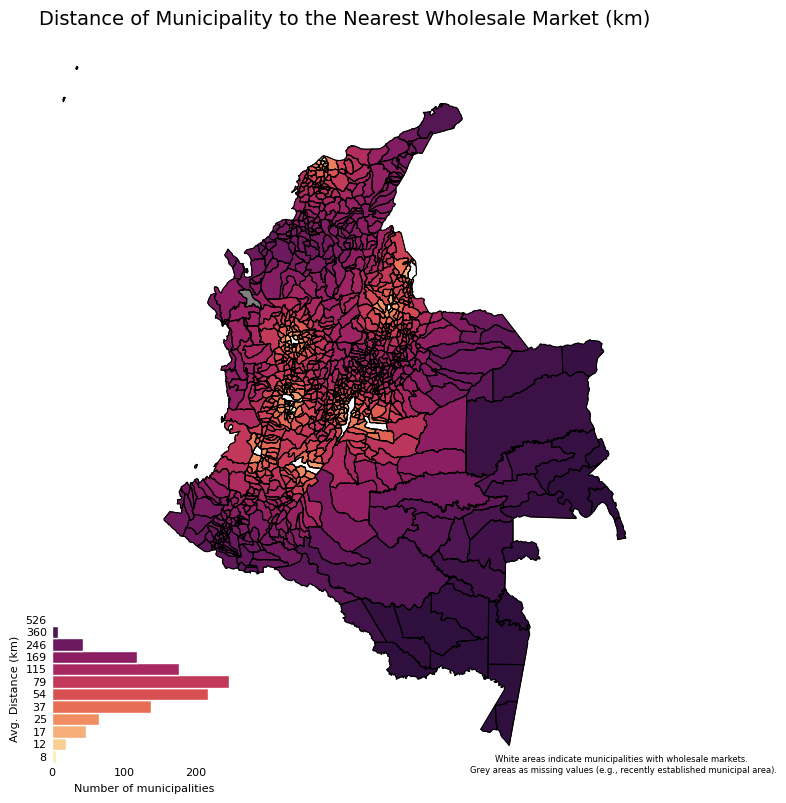

In [521]:
# -------------------------------
# Prepare the Distance Map Data
# -------------------------------

# Replace 0 values in 'discapital' with a small positive number to avoid log(0)
# final_shp["dismdo"] = final_shp["dismdo"].replace(0, 1e-6)

# Define the log normalization for the color mapping
log_norm = mcolors.LogNorm(
    vmin=np.percentile(final_shp["dismdo"].dropna(), 1), 
    vmax=np.percentile(final_shp["dismdo"].dropna(), 99)
)

# -------------------------------
# Create the Main Map
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all municipalities as light grey outlines
shapes.plot(ax=ax, linewidth=0.8, color="white")
shapes.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Plot the municipalities colored by their distance to Bogota using the "Reds" colormap.
# Note: We disable the default legend.
final_shp.plot(
    column="dismdo", cmap=Matter_12.mpl_colormap, linewidth=0.5, edgecolor="black",
    norm=log_norm, legend=False, ax=ax,
    missing_kwds={"color": "grey", "label": "No Data"}
)

ax.set_title("Distance of Municipality to the Nearest Wholesale Market (km)", fontsize=14)
ax.annotate("White areas indicate municipalities with wholesale markets. \nGrey areas as missing values (e.g., recently established municipal area).", xy=(0.95, 0.01), xycoords="axes fraction",
            ha="center", fontsize=6, color="black", bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"))  
ax.axis("off")  # Remove map axis

# -------------------------------
# Create the Inset Histogram Legend
# -------------------------------

# Create an inset axis at the lower left corner
hist_ax = inset_axes(
    ax,
    width="30%",    # Fraction of the main axis width
    height="20%",   # Fraction of the main axis height
    loc="lower left",
    borderpad=1.2
)

# Use the distance values (disbogota) for the histogram.
values = final_shp["discapital"]

# Choose the number of bins and create logarithmically spaced bins using the same limits.
num_bins = 12
bin_edges = np.logspace(np.log10(log_norm.vmin), np.log10(log_norm.vmax), num_bins + 1)
counts, _ = np.histogram(values, bins=bin_edges)

# Use the same "Reds" colormap (via matplotlib) for coloring the histogram bins.
cmap = plt.get_cmap("Oranges")

# Plot each bin as a horizontal bar.
for i in range(num_bins):
    lower_edge = bin_edges[i]
    upper_edge = bin_edges[i+1]
    height = upper_edge - lower_edge
    # Pick a color based on the mid-value of the bin; log_norm maps that value to [0,1]
    mid_val = (lower_edge + upper_edge) / 2
    color = Matter_12.hex_colors[i]  # Use the custom color palette
    
    hist_ax.barh(
        y=lower_edge,
        width=counts[i],
        height=height,
        color=color,
        edgecolor="white",
        align="edge"
    )

# Set the y-axis of the inset to logarithmic scale and match the bin range.
hist_ax.set_yscale("log")
hist_ax.set_ylim(bin_edges[0], bin_edges[-1])

# Remove the inset axis spines for a cleaner look.
for spine in hist_ax.spines.values():
    spine.set_visible(False)

# Place y-ticks at the centers of the bins.
tick_positions = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]

# Create a formatter for the y-tick labels (displaying km without a "%" sign)
def format_tick_label(x, pos):
    if x >= 100:
        return f"{x:.0f}"
    elif x >= 10:
        return f"{x:.0f}"
    else:
        return f"{x:.0f}"

hist_ax.set_yticks(tick_positions)
hist_ax.set_yticklabels([format_tick_label(tp, None) for tp in tick_positions], fontsize=8)

# Label inset axes appropriately
hist_ax.set_xlabel("Number of municipalities", fontsize=8)
hist_ax.set_ylabel("Avg. Distance (km)", fontsize=8)
#hist_ax.set_title("Distribution", fontsize=10)
hist_ax.tick_params(axis="both", which="both", length=0, labelsize=8)

# -------------------------------
# Final Layout and Show
# -------------------------------
plt.tight_layout()
plt.show()


C:\Users\cpedr\AppData\Local\Temp\ipykernel_70600\499828748.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


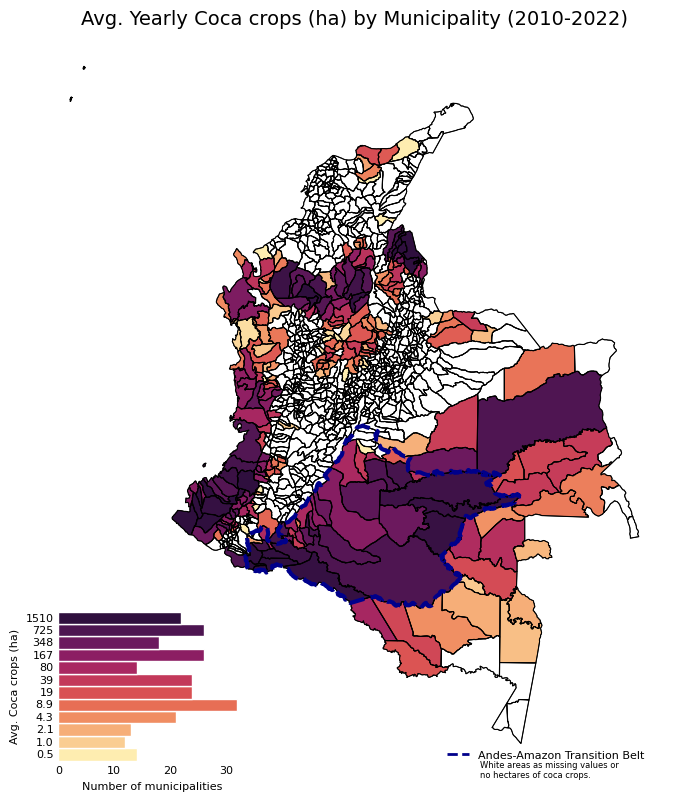

In [753]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

######################################
### Coca crops (coca area in ha)   ###
######################################

# Aggregate yearly coca crops (in hectares) by Municipality
avg_coca = final_df.groupby("codmpio")["H_coca"].mean().reset_index()

# Merge with the spatial layer and ensure geometry is valid
gdf_coca = shapes.merge(avg_coca, on="codmpio", how="left")
gdf_coca = gpd.GeoDataFrame(gdf_coca, geometry="geometry")
gdf_coca = gdf_coca.dropna(subset=["geometry"])
# (Make sure to filter using gdf_coca.is_valid, not gdf.is_valid)
gdf_coca = gdf_coca[gdf_coca.is_valid]

# Replace 0 with NaN to avoid issues with logarithmic scaling
gdf_coca["H_coca"] = gdf_coca["H_coca"].replace(0, np.nan)

# Define log scale normalization based on the 1st and 99th percentiles of H_coca
#vmin = gdf_coca["H_coca"].dropna().min()
#vmax = gdf_coca["H_coca"].dropna().max()
vmin = np.percentile(gdf_coca["H_coca"].dropna(), 5)
vmax = np.percentile(gdf_coca["H_coca"].dropna(), 95)
log_norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

######################################
### Create the Main Map with Coca  ###
######################################

fig, ax = plt.subplots(figsize=(12, 8))

# Plot municipality outlines
shapes.plot(ax=ax, linewidth=0.8, color="white")
shapes.boundary.plot(ax=ax, linewidth=0.8, color="black")

# Plot the transition boundary (if you have this layer)
transition.boundary.plot(ax=ax, linewidth=3, color="darkblue", linestyle="--") 

# Plot coca crops map with the defined colormap and log normalization.
gdf_coca.plot(
    column="H_coca",
    cmap=Matter_12.mpl_colormap,
    linewidth=0.5,
    edgecolor="black",
    norm=log_norm,
    legend=False,  # We turn legend on now but we'll later remove it as we use the inset
    ax=ax,
    missing_kwds={"color": "white", "label": "No Data"}
)

ax.set_title("Avg. Yearly Coca crops (ha) by Municipality (2010-2022)", fontsize=14)
ax.axis("off")

######################################
### Inset Histogram for Coca crops ###
######################################

# Create an inset axis in the lower left corner
hist_ax = inset_axes(
    ax,
    width="30%",    # 30% of the main axis width
    height="20%",   # 20% of the main axis height
    loc="lower left",
    borderpad=1.2
)

# Use the coca crops values for the histogram.
values = gdf_coca["H_coca"].dropna()

# Choose the number of bins and build logarithmically spaced bins based on vmin and vmax.
num_bins = 12
bin_edges = np.logspace(np.log10(vmin), np.log10(vmax), num_bins + 1)
counts, _ = np.histogram(values, bins=bin_edges)



# For each bin, plot a horizontal bar whose color is set by the midpoint value mapping.
for i in range(num_bins):
    lower_edge = bin_edges[i]
    upper_edge = bin_edges[i+1]
    height = upper_edge - lower_edge
    mid_val = (lower_edge + upper_edge) / 2.0  # Bin midpoint
    color = Matter_12.hex_colors[i]  # Use the custom color palette
    
    hist_ax.barh(
        y=lower_edge,
        width=counts[i],
        height=height,
        color=color,
        edgecolor="white",
        align="edge"
    )

# Set inset y-axis to logarithmic scale and set limits.
hist_ax.set_yscale("log")
hist_ax.set_ylim(bin_edges[0], bin_edges[-1])

# Remove inset axis spines for a clean look.
for spine in hist_ax.spines.values():
    spine.set_visible(False)

# Place y-ticks at the center of each bin.
tick_positions = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
def format_tick_label(x, pos):
    # Here we want integer km values; adjust as needed.
    if x >= 100:
        return f"{x:.0f}"
    elif x >= 10:
        return f"{x:.0f}"
    else:
        return f"{x:.1f}"
hist_ax.set_yticks(tick_positions)
hist_ax.set_yticklabels([format_tick_label(tp, None) for tp in tick_positions], fontsize=8)

# Label the inset axes.
hist_ax.set_xlabel("Number of municipalities", fontsize=8)
hist_ax.set_ylabel("Avg. Coca crops (ha)", fontsize=8)
#hist_ax.set_title("Distribution", fontsize=10)
hist_ax.tick_params(axis="both", which="both", length=0, labelsize=8)

######################################
### Transition Belt Legend         ###
######################################

# Create a custom legend handle for the Andes-Amazon Transition Belt.
transition_handle = mlines.Line2D([], [], color="darkblue", linestyle="--", linewidth=2,
                                  label="Andes-Amazon Transition Belt")

# Add this handle as a legend entry in the bottom right corner.
# Note: Because the map might have a default legend from the plot() call, we add an extra artist.
ax.legend(handles=[transition_handle], loc="lower right", 
          bbox_to_anchor=(0.98, 0.01), fontsize=8, frameon=False, title="")
ax.annotate('White areas as missing values or \nno hectares of coca crops.', xy=(0.7, 0.0001), xycoords="axes fraction",
            ha="left", fontsize=6, color="black", bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.5"))

######################################
### Final Layout and Show          ###
######################################
plt.tight_layout()
plt.show()
